# Import all the libraries and packages 

In [1]:
import os
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, Predictive, EmpiricalMarginal
from pyro.infer.autoguide import init_to_mean, init_to_median, init_to_value
from pyro.infer.inspect import get_dependencies
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete

import gempy as gp
import gempy_engine
import gempy_viewer as gpv
from gempy_engine.core.backend_tensor import BackendTensor
import arviz as az
from gempy_probability.plot_posterior import default_red, default_blue, PlotPosterior

from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal, norm

/home/jt925938/anaconda3/envs/gempy_pyro/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setting Backend To: AvailableBackends.numpy


# Get the path of all the data

In [2]:
filename_a = './Fw__Hyperspectral_datasets_from_the_KSL_cores/CuSp131.pkl'
filename_b = './Fw__Hyperspectral_datasets_from_the_KSL_cores/CuSp133.pkl'
filename_c = './Fw__Hyperspectral_datasets_from_the_KSL_cores/CuSp136.pkl'

# Load and get the data

In [3]:
with open(filename_a, 'rb') as myfile:
    a= joblib.load(myfile)

# Description about Hyperspectral data
## Data is obtained by scannig the core data from different boreholes using hyperspectral sensors. There were around 450 channels for each pixels initially. It was preprocessed and seperated based on 10 different types of rocks. In each of the file we have "X", "Y", "Z" coordinates points corresponding to sensors and corresponding to each rock type we have a transformed RGB correspondence information. 

(235,)
(234,)


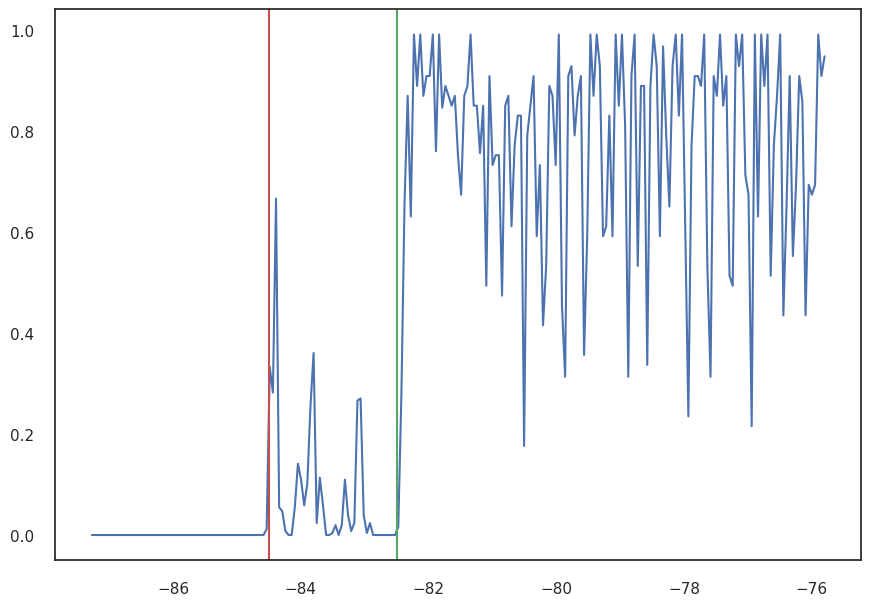

In [4]:
# The variability in "X" and "Y" are much smaller as compared to "Z" direction in case of birehole information. 
# Therefore, we are trying to build our model considering the "Z" direction mostly. 
# get the z-cordinates of borehole
zz = a['XYZ'][:,2]
print(zz.shape)
# sort the z-cordinates
ixx = np.argsort( zz )
# mask if values is less than some specified value
mask = zz[ixx] < -700
ah = a['BR_Anhydrite'][:,0] # correlates to "anhydrite index" derived from hyperspectral 
position_cord , hsi_data = zz[ixx][mask], ah[ixx][mask]/255 # To normalize the hyperspectral spectra, divide it with 255. 
plt.plot( position_cord/10 , hsi_data )
print(position_cord.shape)

# define breakpoints 
# In general it is very difficult to define the breakpoints in the plot. Prepocessing of hyperspectral data is itself a very difficult task
# becasue of high correaltion, high dimensional and noisy data. 
brk1 = -845/10 
brk2 = -825/10 

plt.axvline( brk1, color='r' )
plt.axvline( brk2, color='g')

In [5]:
hsi_data.reshape(1,-1)

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.01176471, 0.33333333, 0.28235294, 0.66666667,
        0.05490196, 0.04705882, 0.00784314, 0.        , 0.        ,
        0.05490196, 0.14117647, 0.10980392, 0.05882353, 0.10196078,
        0.25490196, 0.36078431, 0.02352941, 0.11

# Since it is difficult to classify a hyperspectral data in general. We can apply different classical clustering methods to have some starting guess

In [6]:

#gm = KMeans(n_clusters=3, random_state=42).fit(X)
#gm = GaussianMixture(n_components=3, random_state=0).fit(X)
gm = BayesianGaussianMixture(n_components=3, random_state=0).fit(hsi_data.reshape(-1,1))

In [7]:
gm.means_ , gm.covariances_

(array([[0.4912443 ],
        [0.01853378],
        [0.86780368]]),
 array([[[0.04165404]],
 
        [[0.00509574]],
 
        [[0.01363843]]]))

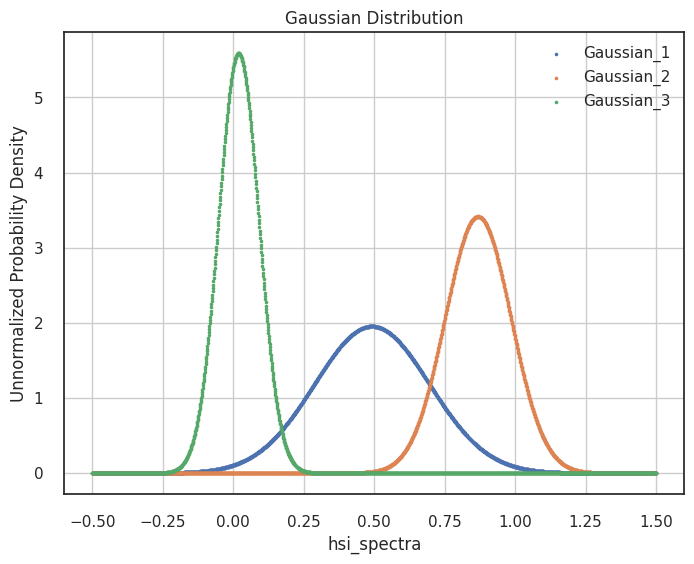

In [8]:

loc_mean_init, loc_var_init = gm.means_[[0,2,1]], np.sqrt(gm.covariances_[[0,2,1]])
# Create a grid of points
plt.figure(figsize=(8, 6))
x = np.linspace(-0.5,1.5,2000)
  # Combine x and y grids into a (100, 100, 2) array
for i in range(3):
    # Create a multivariate normal distribution
    rv = norm(loc_mean_init[i], loc_var_init[i])

    # Calculate PDF values for each point in the grid
    pdf_values = rv.pdf(x)

    # Plot the Gaussian distribution using contour plot
    
    plt.scatter(x, pdf_values, s=2.5, label='Gaussian_'+str(i+1))
#plt.colorbar(label='Probability Density')
plt.xlabel('hsi_spectra')
plt.ylabel('Unnormalized Probability Density')
plt.title('Gaussian Distribution')
#plt.scatter(loc_mean[i], color='red', label='Mean')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
y_gmm_label = gm.predict(hsi_data.reshape(-1,1))
print(y_gmm_label)
y_gmm_label_arranged = np.zeros_like(y_gmm_label)
y_gmm_label_arranged[y_gmm_label == 1] = 3
y_gmm_label_arranged[y_gmm_label == 0] = 2
y_gmm_label_arranged[y_gmm_label == 2] = 1
y_gmm_label_arranged = torch.Tensor(y_gmm_label_arranged)
y_gmm_label_arranged 

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 2 1 1 1 1 1 1 1 1 1 1 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 2 2 0 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 0 2 2 0 2 2 2 1 2 2 2 0 2 0 0 2 2
 2 2 0 0 2 2 2 2 2 0 0 2 2 2 2 0 0 2 0 2 2 2 2 0 2 2 0 2 2 0 2 2 2 0 2 2 0
 2 2 2 2 0 0 2 2 2 2 2 0 0 2 2 2 2 2 0 0 2 2 2 2 2 0 2 0 2 2 2 0 2 2 2 0 0
 2 0 2 2 2 0 2 2 2 2 2 2]


tensor([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 2., 2., 1., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 2., 2.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 2., 2., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 2., 1., 1., 2., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        2., 1., 1., 1., 1., 2., 1., 1., 2., 1., 1., 1., 3., 1., 1., 1., 2., 1.,
        2., 2., 1., 1., 1., 1., 2., 2., 1., 1., 1., 1., 1., 2., 2., 1., 1., 1.,
        1., 2., 2., 1., 2., 1., 1., 1., 1., 2., 1., 1., 2., 1., 1., 2., 1., 1.,
        1., 2., 1., 1., 2., 1., 1., 1., 1., 2., 2., 1., 1., 1., 1., 1., 2., 2.,
        1., 1., 1., 1., 1., 2., 2., 1., 1., 1., 1., 1., 2., 1., 2., 1., 1., 1.,
        2., 1., 1., 1., 2., 2., 1., 2., 

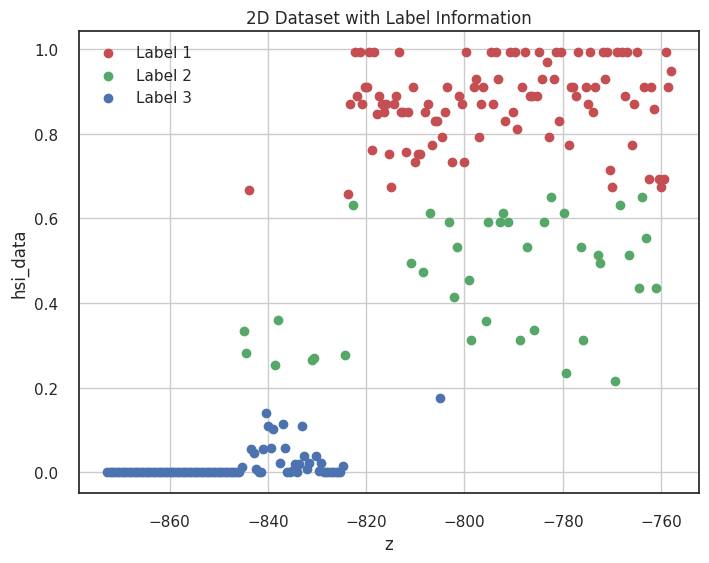

In [10]:
import matplotlib.pyplot as plt
# Define colors for each label
colors = ['r', 'g', 'b']
labels = y_gmm_label_arranged

# Plot the dataset with different colors for each label
plt.figure(figsize=(8, 6))
for label_val, color in zip([1,2,3], colors):
    plt.scatter(position_cord[labels == label_val], hsi_data[labels == label_val], c=color, label=f'Label {label_val}')

plt.xlabel('z')
plt.ylabel('hsi_data')
plt.title('2D Dataset with Label Information')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# A = np.zeros_like(a['BR_Anhydrite'][:, 0])
# B = np.zeros_like(a['BR_Anhydrite'][:, 0])
# C = np.zeros_like(a['BR_Anhydrite'][:, 0])

A = np.zeros_like(hsi_data)
B = np.zeros_like(hsi_data)
C = np.zeros_like(hsi_data)

# Get indices where the mask is True
# indices_A = np.where(mask & (zz[ixx] < brk1))
# indices_B = np.where(mask & (zz[ixx] > brk1) & (zz[ixx] < brk2))
# indices_C = np.where(mask & (zz[ixx] > brk2))
shift =0
# Get indices where the mask is True
indices_A = np.where(mask & (zz[ixx] < (brk1+shift)))
indices_B = np.where(mask & (zz[ixx] > (brk1+shift)) & (zz[ixx] < (brk2+shift)))
indices_C = np.where(mask & (zz[ixx] > (brk2+shift)))

y_obs_label = torch.ones(234)
y_obs_label[indices_A] =3
y_obs_label[indices_B] = 2
y_obs_label

tensor([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 

In [12]:
matched_label = y_obs_label == y_gmm_label_arranged
(matched_label.sum()/len(y_obs_label)) *100

tensor(39.7436)

# We use the normalised hsi data y_obs_label information

In [13]:

y_obs_label = hsi_data.reshape((-1,1))
y_obs_label

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.   

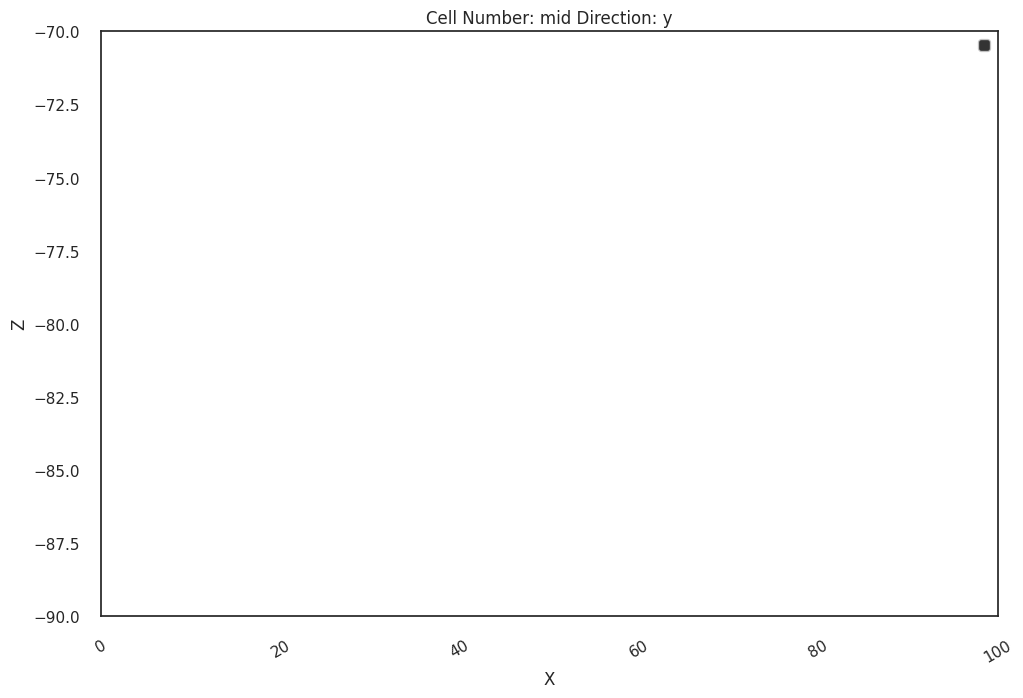

In [14]:
geo_model_test = gp.create_geomodel(
    project_name='Gempy_abc_Test',
    extent=[0, 100, -50, 50, -90, -70],
    resolution=[100,100,100],
    refinement=3,
    structural_frame= gp.data.StructuralFrame.initialize_default_structure()
    )
p2d = gpv.plot_2d(geo_model_test)

In [15]:
geo_model_test.grid.active_grids_bool

array([False, False, False, False, False])

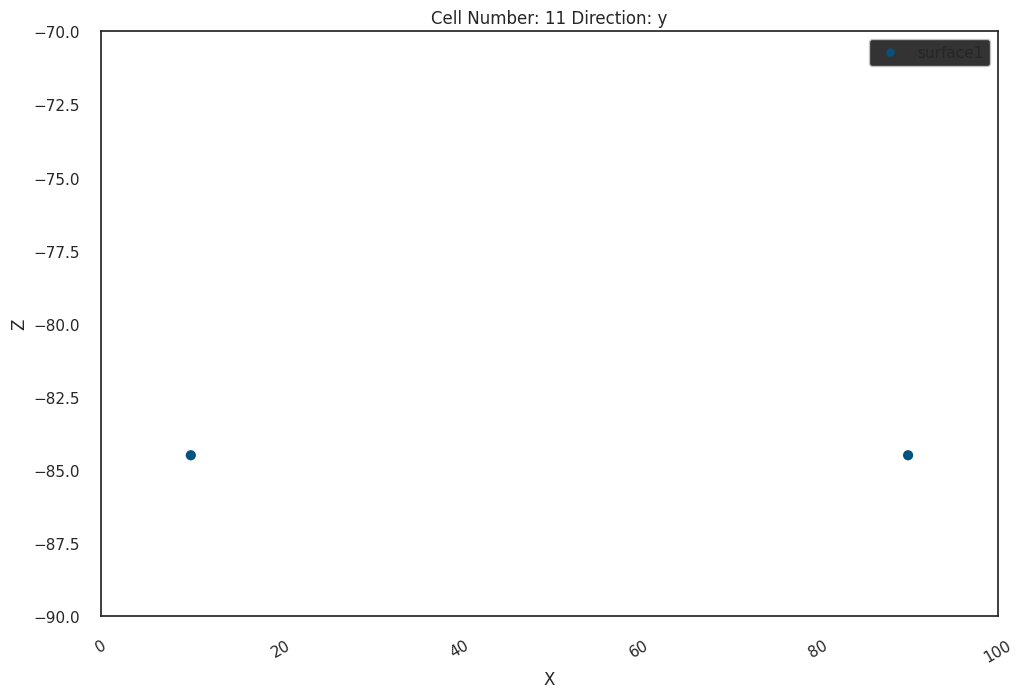

In [16]:
gp.add_surface_points(
    geo_model=geo_model_test,
    x=[10.0, 90.0],
    y=[0.0, 0.0],
    z=[brk1, brk1],
    elements_names=['surface1', 'surface1']
)

gpv.plot_2d(geo_model_test, cell_number=11)

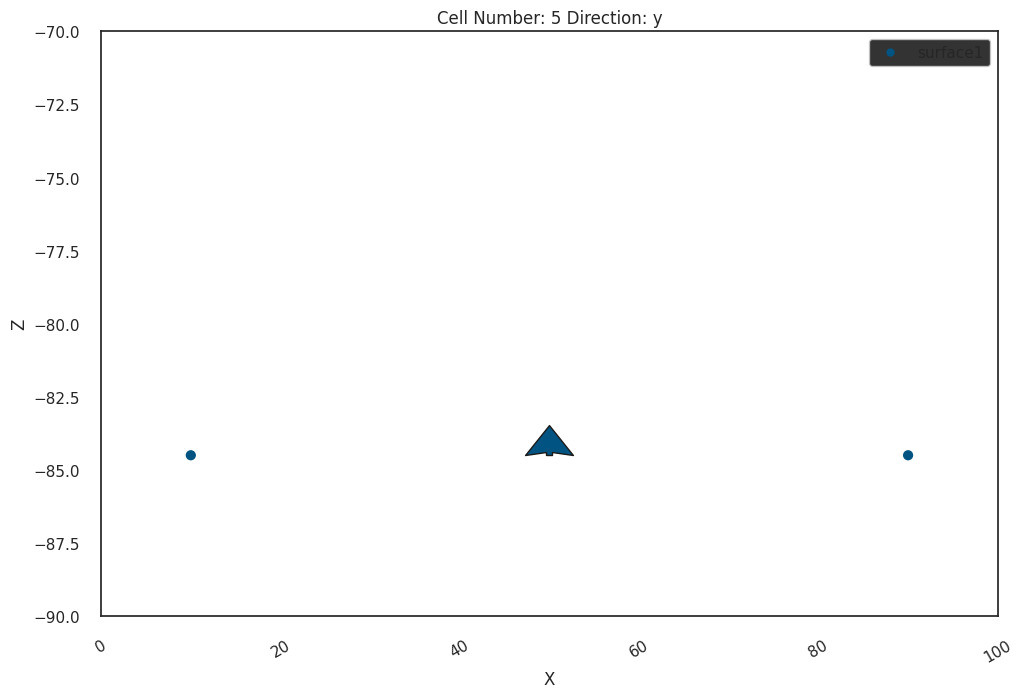

In [17]:
gp.add_orientations(
    geo_model=geo_model_test,
    x=[50],
    y=[0.0],
    z=[brk1],
    elements_names=['surface1'],
    pole_vector=[[0, 0, 1]]
)

gpv.plot_2d(geo_model_test, cell_number=5)

In [18]:
geo_model_test.update_transform(gp.data.GlobalAnisotropy.NONE)

In [19]:
gp.compute_model(geo_model_test, engine_config=gp.data.GemPyEngineConfig())

Setting Backend To: AvailableBackends.numpy


/home/jt925938/anaconda3/envs/gempy_pyro/lib/python3.10/site-packages/gempy/core/data/geo_model.py:164: UserWarning: You are using refinement and passing a regular grid. The resolution of the regular grid will be overwritten
  warnings.warn(


Solutions(3 Octree Levels, 1 DualContouringMeshes)

In [20]:
geo_model_test.interpolation_options.kernel_options

KernelOptions(range=5, c_o=10, uni_degree=1, i_res=4, gi_res=2, number_dimensions=3, kernel_function=AvailableKernelFunctions.cubic, compute_condition_number=False, kernel_solver=Solvers.DEFAULT)

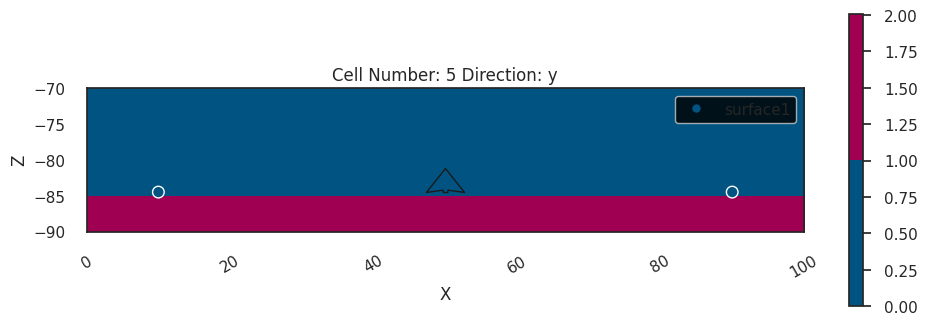

In [21]:
gpv.plot_2d(geo_model_test, cell_number=[5])

In [22]:
#gpv.plot_3d(geo_model_test, show_surfaces=True, image=True)

In [23]:
geo_model_test.structural_frame

StructuralFrame(
	structural_groups=[
StructuralGroup(
	name=default_formations,
	structural_relation=StackRelationType.ERODE,
	elements=[
Element(
	name=surface1,
	color=#015482,
	is_active=True
)
]
)
],
	fault_relations=
[[False]],

Setting Backend To: AvailableBackends.numpy


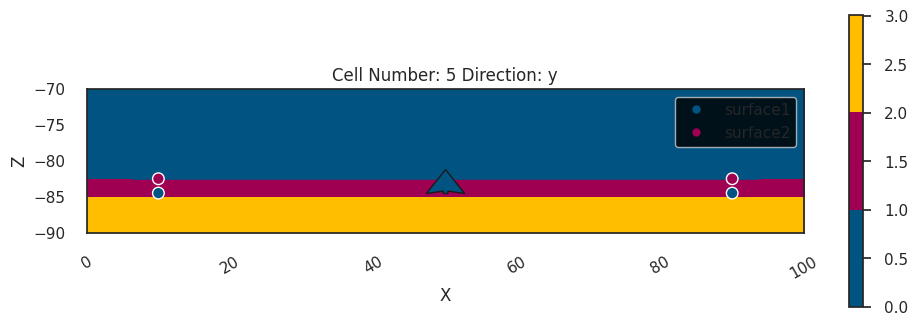

In [24]:
element2 = gp.data.StructuralElement(
    name='surface2',
    color=next(geo_model_test.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=np.array([10.0, 90.0]),
        y=np.array([0.0, 0.0]),
        z=np.array([brk2, brk2]),
        names='surface2'
    ),
    orientations=gp.data.OrientationsTable.initialize_empty()
)

geo_model_test.structural_frame.structural_groups[0].append_element(element2)
# Compute and visualize the updated model:
gp.compute_model(geo_model_test)
gpv.plot_2d(geo_model_test, cell_number=5, legend='force')
    

In [25]:
#gpv.plot_3d(geo_model_test, image=True)

In [26]:
geo_model_test.structural_frame

StructuralFrame(
	structural_groups=[
StructuralGroup(
	name=default_formations,
	structural_relation=StackRelationType.ERODE,
	elements=[
Element(
	name=surface1,
	color=#015482,
	is_active=True
),
Element(
	name=surface2,
	color=#9f0052,
	is_active=True
)
]
)
],
	fault_relations=
[[False]],

In [27]:
geo_model_test.structural_frame.structural_groups[0].elements[0], geo_model_test.structural_frame.structural_groups[0].elements[1] = \
geo_model_test.structural_frame.structural_groups[0].elements[1], geo_model_test.structural_frame.structural_groups[0].elements[0]

In [28]:
geo_model_test.structural_frame

StructuralFrame(
	structural_groups=[
StructuralGroup(
	name=default_formations,
	structural_relation=StackRelationType.ERODE,
	elements=[
Element(
	name=surface2,
	color=#9f0052,
	is_active=True
),
Element(
	name=surface1,
	color=#015482,
	is_active=True
)
]
)
],
	fault_relations=
[[False]],

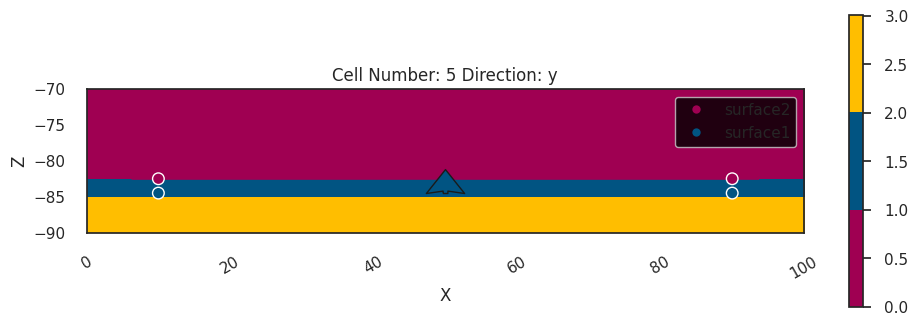

In [29]:
gpv.plot_2d(geo_model_test, cell_number=5, legend='force')

# Create a custome grid where the observed data information is available 

In [30]:
x_loc = 30
y_loc = 0
z_loc = position_cord
xyz_coord = np.array([[x_loc, y_loc, z] for z in z_loc])
gp.set_custom_grid(geo_model_test.grid, xyz_coord=xyz_coord)

Active grids: ['custom']


In [31]:
sp_coords_copy_test = geo_model_test.interpolation_input.surface_points.sp_coords.copy()
geo_model_test.transform.apply_inverse(sp_coords_copy_test)

array([[ 10. ,   0. , -82.5],
       [ 90. ,   0. , -82.5],
       [ 10. ,   0. , -84.5],
       [ 90. ,   0. , -84.5]])

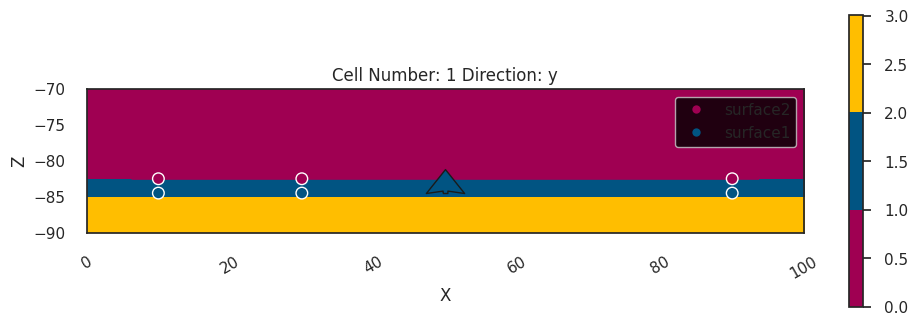

In [32]:
gp.add_surface_points(
    geo_model=geo_model_test,
    x=[x_loc, x_loc],
    y=[0.0, 0.0],
    z=[brk1, brk2],
    elements_names=['surface1', 'surface2']
)
gpv.plot_2d(geo_model_test, cell_number=1)

In [33]:
geo_model_test.surface_points

X,Y,Z,id,nugget
10.00,0.00,-82.50,75452914,0.00
90.00,0.00,-82.50,75452914,0.00
30.00,0.00,-82.50,75452914,0.00
10.00,0.00,-84.50,2054985,0.00
90.00,0.00,-84.50,2054985,0.00
30.00,0.00,-84.50,2054985,0.00


Setting Backend To: AvailableBackends.numpy


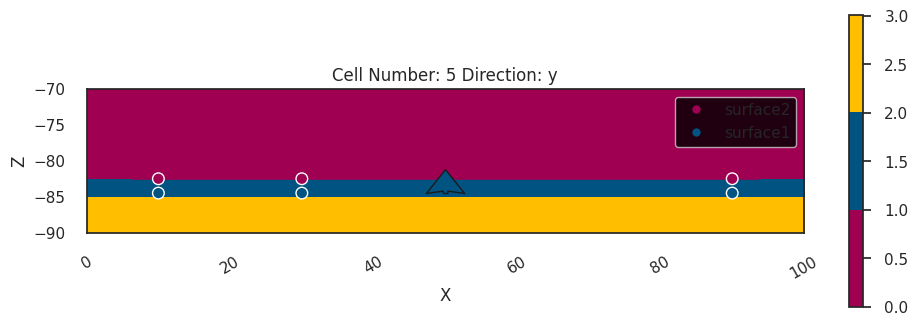

In [34]:
gp.compute_model(geo_model_test)
gpv.plot_2d(geo_model_test, cell_number=5, legend='force')

In [35]:
sp_coords_copy_test = geo_model_test.interpolation_input.surface_points.sp_coords.copy()
geo_model_test.transform.apply_inverse(sp_coords_copy_test)

array([[ 10. ,   0. , -82.5],
       [ 90. ,   0. , -82.5],
       [ 30. ,   0. , -82.5],
       [ 10. ,   0. , -84.5],
       [ 90. ,   0. , -84.5],
       [ 30. ,   0. , -84.5]])

In [36]:
# Change the backend to PyTorch for probabilistic modeling
BackendTensor.change_backend_gempy(engine_backend=gp.data.AvailableBackends.PYTORCH)

Setting Backend To: AvailableBackends.PYTORCH


In [37]:
geo_model_test.interpolation_options.uni_degree = 0
geo_model_test.interpolation_options.mesh_extraction = False
geo_model_test.interpolation_options.sigmoid_slope = 1100.
geo_model_test.interpolation_options.kernel_options.range=5.0

In [38]:
#geo_model_test.solutions.octrees_output[0].last_output_center

In [39]:
custom_grid_values = geo_model_test.solutions.octrees_output[0].last_output_center.custom_grid_values
custom_grid_values.shape

(234,)

In [40]:
y_obs_label.shape

(234, 1)

In [41]:
geo_model_test.surface_points

X,Y,Z,id,nugget
10.00,0.00,-82.50,75452914,0.00
90.00,0.00,-82.50,75452914,0.00
30.00,0.00,-82.50,75452914,0.00
10.00,0.00,-84.50,2054985,0.00
90.00,0.00,-84.50,2054985,0.00
30.00,0.00,-84.50,2054985,0.00


In [42]:
geo_model_test.orientations

X,Y,Z,G_x,G_y,G_z,id,nugget
50.00,0.00,-84.50,0.00,0.00,1.00,2054985,0.01


In [43]:
print(sp_coords_copy_test)
geo_model_test.transform.apply_inverse(sp_coords_copy_test)

[[-0.25    0.      0.0125]
 [ 0.25    0.      0.0125]
 [-0.125   0.      0.0125]
 [-0.25    0.      0.    ]
 [ 0.25    0.      0.    ]
 [-0.125   0.      0.    ]]


array([[ 10. ,   0. , -82.5],
       [ 90. ,   0. , -82.5],
       [ 30. ,   0. , -82.5],
       [ 10. ,   0. , -84.5],
       [ 90. ,   0. , -84.5],
       [ 30. ,   0. , -84.5]])

Condition number: 52611.08230261848.
Condition number: 52611.08230261848.


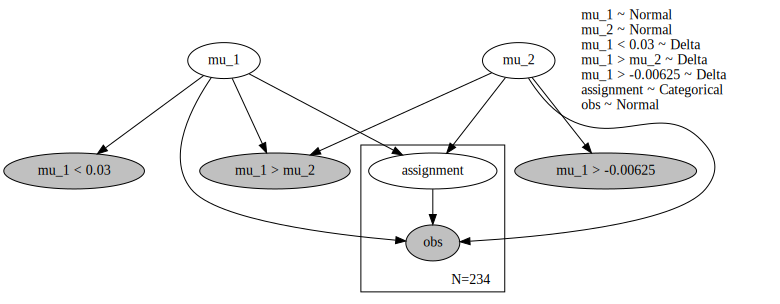

In [44]:
y_obs_label = torch.tensor(y_obs_label,dtype=torch.float64)


@config_enumerate
def model_test(obs_data):
    """
    This Pyro model represents the probabilistic aspects of the geological model.
    It defines a prior distribution for the top layer's location and
    computes the thickness of the geological layer as an observed variable.
    """
    # Define prior for the top layer's location
    prior_mean_surface_1 = sp_coords_copy_test[2, 2]
    prior_mean_surface_2 = sp_coords_copy_test[5, 2]
    
    

    
    mu_surface_1 = pyro.sample('mu_1', dist.Normal(prior_mean_surface_1, torch.tensor(0.00625, dtype=torch.float64)))
    mu_surface_2 = pyro.sample('mu_2', dist.Normal(prior_mean_surface_2, torch.tensor(0.00625, dtype=torch.float64)))
    
    # Ensure that mu_surface_1 is greater than mu_surface_2
    pyro.sample('mu_1 < 0.03', dist.Delta(torch.tensor(1.0, dtype=torch.float64)), obs=(mu_surface_1 <0.03))
    pyro.sample('mu_1 > mu_2', dist.Delta(torch.tensor(1.0, dtype=torch.float64)), obs=(mu_surface_1 > mu_surface_2))
    pyro.sample('mu_1 > -0.00625', dist.Delta(torch.tensor(1.0, dtype=torch.float64)), obs=(mu_surface_2 > -0.00625))
    # Update the model with the new top layer's location
    interpolation_input = geo_model_test.interpolation_input
    
    
    interpolation_input.surface_points.sp_coords = torch.index_put(
        interpolation_input.surface_points.sp_coords,
        (torch.tensor([2]), torch.tensor([2])),
        mu_surface_1
    )
    interpolation_input.surface_points.sp_coords = torch.index_put(
        interpolation_input.surface_points.sp_coords,
        (torch.tensor([5]), torch.tensor([2])),
        mu_surface_2
    )
    
    
    # # Compute the geological model
    geo_model_test.solutions = gempy_engine.compute_model(
        interpolation_input=interpolation_input,
        options=geo_model_test.interpolation_options,
        data_descriptor=geo_model_test.input_data_descriptor,
        geophysics_input=geo_model_test.geophysics_input,
    )
    
    # Compute and observe the thickness of the geological layer
    
    custom_grid_values = geo_model_test.solutions.octrees_output[0].last_output_center.custom_grid_values
    
    lambda_ = 5
    #class_label = F.softmax(-lambda_* (torch.tensor([1,2,3], dtype=torch.float64) - custom_grid_values.reshape(-1,1))**2, dim=1)
    z_nk = F.softmax(-lambda_* (torch.tensor([1,2,3], dtype=torch.float64) - custom_grid_values.reshape(-1,1))**2, dim=1)
    N_k = torch.sum(z_nk,axis=0)
    N = len(custom_grid_values)
    pi_k = N_k /N
    mean = []
    cov = []
    #print("Z_nk",z_nk.shape)
    for i in range(z_nk.shape[1]):
            mean_k = torch.sum( z_nk[:,i][:,None] * obs_data, axis=0)/ N_k[i]
            #print("mean_k",mean_k.shape[0])
            #cov_k = torch.sum( (normalised_hsi - mean_k.reshape((-1,1))) (normalised_hsi - mean_k).T )
            cov_k = torch.tensor(0.0,dtype=torch.float64)
            for j in range(z_nk.shape[0]):
                 #cov_k +=  z_nk[j,i]* torch.matmul((obs_data[j,:] - mean_k).reshape((-1,1)) ,(obs_data[j,:] - mean_k).reshape((1,-1)))
                 cov_k +=  z_nk[j,i]* (obs_data[j,:] - mean_k)[0] * (obs_data[j,:] - mean_k)[0]
            mean.append(mean_k)
            cov_k=cov_k/N_k[i] #+ 1e-3 * torch.diag(torch.ones(cov_k.shape[0],dtype=torch.float64))
            cov.append(cov_k)
    mean_tensor = torch.stack(mean, dim=0).reshape(-1)
    cov_tensor = torch.stack(cov,dim=0)
    #print(mean_tensor.shape, cov_tensor.shape, obs_data.shape)
    with pyro.plate('N='+str(y_obs_label.shape[0]), y_obs_label.shape[0]):
        assignment = pyro.sample("assignment", dist.Categorical(pi_k))
        #print(mean_tensor[assignment].shape, cov_tensor[assignment].shape)
        obs = pyro.sample("obs", dist.Normal(mean_tensor[assignment], torch.sqrt(cov_tensor[assignment]) ), obs=obs_data.reshape(-1))
    #return obs
dependencies = get_dependencies(model_test, model_args=(y_obs_label,))
pyro.render_model(model_test, model_args=(y_obs_label,),render_distributions=True)

In [45]:
print(y_obs_label.shape)
# model_test(y_obs_label)

torch.Size([234, 1])


Condition number: 52611.08230261848.
Condition number: 53204.11018324266.
Condition number: 54263.941065690386.
Condition number: 53030.4559126162.
Condition number: 45401.09254281982.
Condition number: 42367.91497775892.
Condition number: 27473.47190974987.
Condition number: 54278.31182541241.
Condition number: 46821.71826916326.
Condition number: 54077.20188894339.
Condition number: 25649.346966016885.
Condition number: 45864.34293708616.
Condition number: 53625.1027892914.
Condition number: 52142.549109508866.
Condition number: 32370.214204386717.
Condition number: 36040.99073723484.
Condition number: 54287.08115989122.
Condition number: 39629.64155652377.
Condition number: 33470.85943558009.
Condition number: 49954.18162009801.
Condition number: 53917.096879186225.
Condition number: 38643.30671267236.
Condition number: 46740.0254488243.
Condition number: 52277.11598981176.
Condition number: 23206.954789767737.
Condition number: 52735.43311287647.
Condition number: 54536.65109419123

/home/jt925938/anaconda3/envs/gempy_pyro/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


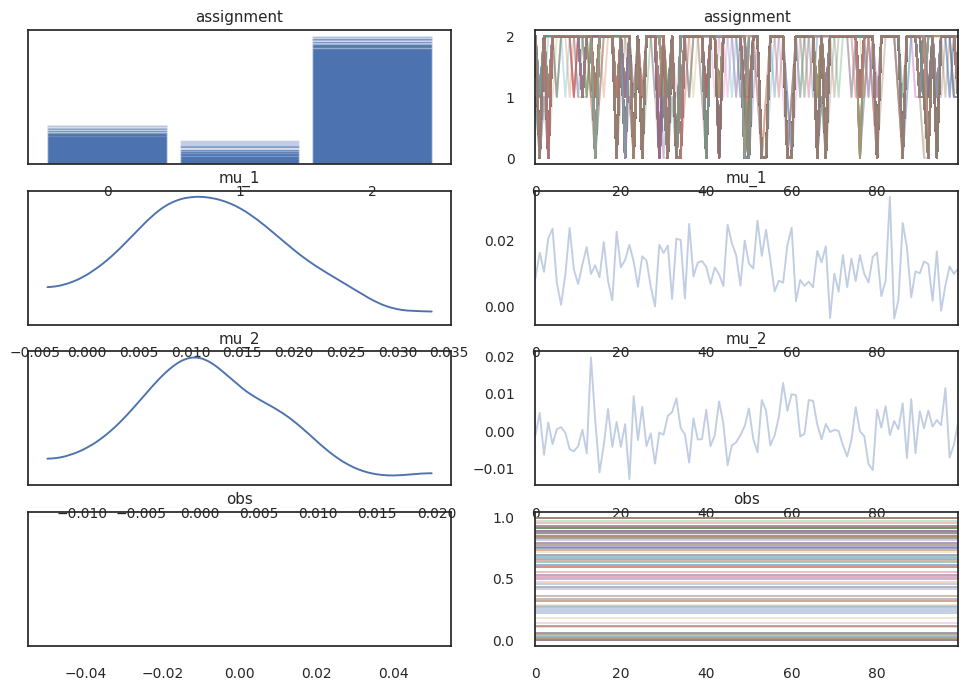

: 

In [ ]:
prior = Predictive(model_test, num_samples=100)(y_obs_label)

# Key to avoid
avoid_key = ['mu_1 > mu_2','mu_1 < 0.03','mu_1 > -0.00625']

# Create sub-dictionary without the avoid_key
prior = dict((key, value) for key, value in prior.items() if key not in avoid_key)

data = az.from_pyro(prior=prior)
az.plot_trace(data.prior)
plt.show()

In [ ]:
pyro.primitives.enable_validation(is_validate=True)
nuts_kernel = NUTS(model_test, step_size=0.0085, adapt_step_size=True, target_accept_prob=0.9, max_tree_depth=10, init_strategy=init_to_mean)
#nuts_kernel = NUTS(model_test, step_size=0.00085, adapt_step_size=True, target_accept_prob=0.9, max_tree_depth=10)
#nuts_kernel = NUTS(model_test)
initial_values = {'mu_1': torch.tensor(0.01, dtype=torch.float64),'mu_2': torch.tensor(0.01, dtype=torch.float64) }
#mcmc = MCMC(nuts_kernel, num_samples=200, warmup_steps=50, disable_validation=False, initial_params=initial_values)
mcmc = MCMC(nuts_kernel, num_samples=100, warmup_steps=50, disable_validation=False)
mcmc.run(y_obs_label)

Warmup:   0%|          | 0/150 [00:00, ?it/s]

Condition number: 54589.80489559428.
Condition number: 52007.342764725225.
Condition number: 52007.342764725225.
Condition number: 52007.342764725225.
Condition number: 52007.342764725225.
Condition number: 52007.342764725225.
Condition number: 134371.06730455943.
Condition number: 52007.342764725225.
Condition number: 24165.73412773482.
Condition number: 52007.342764725225.
Condition number: 52799.35519950836.
Condition number: 52007.342764725225.
Condition number: 52634.379270780104.
Condition number: 52007.342764725225.
Condition number: 52067.22410147635.
Condition number: 52007.342764725225.
Condition number: 51708.56595267921.
Condition number: 52007.342764725225.
Condition number: 51680.356235326064.
Condition number: 52007.342764725225.
Condition number: 52086.42626486559.
Condition number: 52239.18497340706.
Condition number: 51785.91594418661.
Condition number: 51593.49301592797.


Warmup:   1%|▏         | 2/150 [00:01,  1.47it/s, step size=1.11e-05, acc. prob=0.032]

Condition number: 51833.0993586262.
Condition number: 52264.322958517085.
Condition number: 52473.24045828329.
Condition number: 51986.11668571408.
Condition number: 51965.39218234671.
Condition number: 51945.206845292734.
Condition number: 51925.55440324064.
Condition number: 51906.39992112488.
Condition number: 51887.93610632196.
Condition number: 51870.299265597096.
Condition number: 51852.60616125935.
Condition number: 51832.21169965949.


Warmup:   2%|▏         | 3/150 [00:02,  1.50it/s, step size=6.50e-06, acc. prob=0.321]

Condition number: 51808.586279698095.
Condition number: 51781.71227438171.
Condition number: 51884.49797021052.
Condition number: 51891.67732432727.
Condition number: 51895.701632311764.
Condition number: 51881.36877281747.
Condition number: 51878.54918124309.
Condition number: 51876.03926390478.


Warmup:   3%|▎         | 4/150 [00:02,  1.75it/s, step size=6.13e-06, acc. prob=0.490]

Condition number: 51873.84040426954.
Condition number: 51891.54001602516.
Condition number: 51891.65169072274.
Condition number: 51891.9993902732.
Condition number: 51892.06889718269.
Condition number: 51892.71457053537.


Warmup:   3%|▎         | 5/150 [00:03,  1.74it/s, step size=6.74e-06, acc. prob=0.592]

Condition number: 51893.60873542435.
Condition number: 51894.73811427363.
Condition number: 51905.46579926959.
Condition number: 51882.01361359194.
Condition number: 51870.68203277922.
Condition number: 51859.603453484495.
Condition number: 51848.74917092759.
Condition number: 51838.061423688814.
Condition number: 51827.43906276373.
Condition number: 51816.7289151002.
Condition number: 51805.74169931024.
Condition number: 51794.29906503002.
Condition number: 51782.2837596222.
Condition number: 51769.665996531476.
Condition number: 51756.51019760441.
Condition number: 51742.96541842725.
Condition number: 51729.22795869455.
Condition number: 51715.486012973495.
Condition number: 51701.88321901043.
Condition number: 51688.5144515692.
Condition number: 51675.43752487727.
Condition number: 51662.685616608556.
Condition number: 51650.27529332113.
Condition number: 51638.2097355651.
Condition number: 51626.4772901514.
Condition number: 51615.04501984738.
Condition number: 51603.84644666845.
C

Warmup:   4%|▍         | 6/150 [00:06,  1.65s/it, step size=8.04e-06, acc. prob=0.660]

Condition number: 52261.50450240564.
Condition number: 51678.45211249702.
Condition number: 51668.844450254386.
Condition number: 51659.67749277321.
Condition number: 51699.01364156362.
Condition number: 51709.89645428299.
Condition number: 51721.05904198337.
Condition number: 51732.3248463573.


Warmup:   5%|▍         | 7/150 [00:07,  1.25s/it, step size=1.02e-05, acc. prob=0.708]

Condition number: 51718.70321077545.
Condition number: 51728.10386808662.
Condition number: 51738.12080445049.
Condition number: 51701.557027401184.


Warmup:   5%|▌         | 8/150 [00:07,  1.02it/s, step size=1.28e-05, acc. prob=0.743]

Condition number: 51693.40717480008.
Condition number: 51684.99653537847.
Condition number: 51675.82828907721.
Condition number: 51742.85722090704.
Condition number: 51784.56455790365.
Condition number: 51826.74742097296.
Condition number: 51660.31576742291.
Condition number: 51618.46417989247.
Condition number: 51575.28053262735.
Condition number: 51530.52642843868.
Condition number: 51484.66839664903.
Condition number: 51438.53066755807.
Condition number: 51392.790601615576.
Condition number: 51347.808400446935.
Condition number: 51303.64646034923.
Condition number: 51260.039974191895.
Condition number: 51216.30022646579.
Condition number: 51171.403634900365.
Condition number: 51869.26058498679.
Condition number: 51911.74452052439.
Condition number: 51953.65086380064.
Condition number: 51994.49132783817.
Condition number: 52034.19259736121.
Condition number: 52073.13074390357.
Condition number: 52111.80565105283.
Condition number: 52150.53732166423.
Condition number: 52189.4326162523

Warmup:   6%|▌         | 9/150 [01:01, 17.54s/it, step size=1.59e-05, acc. prob=0.769]

Condition number: 41527.366642124565.
Condition number: 41647.64141397202.
Condition number: 41685.9052549727.
Condition number: 41715.8572203675.
Condition number: 41747.196434603604.
Condition number: 41787.18500397373.
Condition number: 41839.11671734626.
Condition number: 41454.95453144503.
Condition number: 41386.59693672734.
Condition number: 41328.5279130274.
Condition number: 41283.07032024149.
Condition number: 41248.95242023003.
Condition number: 41221.03952340248.
Condition number: 41190.39650435522.
Condition number: 41147.5495469088.
Condition number: 41902.67778083896.
Condition number: 41973.92322714578.
Condition number: 42045.066173097584.
Condition number: 42106.63560131738.
Condition number: 42153.25580300199.
Condition number: 42187.7486206456.
Condition number: 42218.901147863304.
Condition number: 42255.40624317433.
Condition number: 42302.354811318364.
Condition number: 42361.08677274579.
Condition number: 42429.48488427896.
Condition number: 42501.67132957837.
C

Warmup:   7%|▋         | 10/150 [01:50, 27.22s/it, step size=2.14e-05, acc. prob=0.791]

Condition number: 54370.42023230915.
Condition number: 32334.237262486517.
Condition number: 32357.107653533345.
Condition number: 32315.024581760616.
Condition number: 32302.26000922914.
Condition number: 32295.62290095344.
Condition number: 32321.68892450965.
Condition number: 32368.373983170666.


Warmup:   8%|▊         | 12/150 [01:51, 13.29s/it, step size=1.85e-05, acc. prob=0.805]

Condition number: 32371.367314372637.
Condition number: 32259.400045703194.
Condition number: 32189.986808401936.
Condition number: 32272.721613209007.
Condition number: 32262.95807059809.
Condition number: 32282.830936597296.
Condition number: 32294.746989764993.
Condition number: 32310.52708098408.


Warmup:   9%|▊         | 13/150 [01:51,  9.39s/it, step size=2.58e-05, acc. prob=0.820]

Condition number: 32307.225939040945.
Condition number: 32285.551406221643.
Condition number: 32319.88718312224.
Condition number: 32241.925453194635.
Condition number: 32186.373656887466.
Condition number: 32359.15323113859.
Condition number: 32411.33115333222.
Condition number: 32470.20505125236.
Condition number: 32521.588678031145.
Condition number: 32131.684665316658.
Condition number: 32089.18939877971.
Condition number: 32056.461968761727.
Condition number: 32019.573973369366.
Condition number: 31969.31836173174.
Condition number: 31914.17695493736.
Condition number: 31868.472588831533.
Condition number: 31835.287920600138.
Condition number: 31803.282444443037.
Condition number: 31759.041610536067.
Condition number: 31705.343270680583.
Condition number: 31657.22956931767.
Condition number: 31622.52753997143.
Condition number: 31593.534922703035.
Condition number: 31555.006177806903.
Condition number: 31504.084600854756.
Condition number: 31454.6562127811.
Condition number: 31418

Warmup:   9%|▉         | 14/150 [02:11, 12.53s/it, step size=3.53e-05, acc. prob=0.833]

Condition number: 26781.276979347906.
Condition number: 26772.013229195105.
Condition number: 26752.353088039774.
Condition number: 27457.746986264.
Condition number: 27548.157761358587.
Condition number: 27479.202033783753.
Condition number: 27506.537599087605.
Condition number: 27419.252976657604.
Condition number: 27451.59701247485.
Condition number: 27455.902285621716.
Condition number: 27564.97501032163.
Condition number: 27616.517969746674.
Condition number: 27470.62895763247.
Condition number: 27533.694626446173.
Condition number: 27769.210128495124.
Condition number: 27424.560657440492.


Warmup:  10%|█         | 15/150 [02:12,  9.05s/it, step size=7.20e-06, acc. prob=0.803]

Condition number: 27301.886029946178.
Condition number: 27314.829447579596.
Condition number: 27450.156988734372.
Condition number: 27456.797871258987.
Condition number: 27453.13410668119.
Condition number: 27440.24804179907.
Condition number: 27427.636136441073.
Condition number: 27414.150205336548.
Condition number: 27401.55931369767.
Condition number: 27391.28844248768.
Condition number: 27384.311129257374.
Condition number: 27381.14838216571.
Condition number: 27381.89365146757.
Condition number: 27386.219131647595.
Condition number: 27393.355562692126.
Condition number: 27402.072891159678.
Condition number: 27410.728292102263.
Condition number: 27417.467365208413.
Condition number: 27420.60420110504.
Condition number: 27419.066782255355.
Condition number: 27412.710758927336.
Condition number: 27402.36352574182.
Condition number: 27389.580204898433.
Condition number: 27376.215738962997.
Condition number: 27364.00651295945.
Condition number: 27354.313481365214.
Condition number: 273

Warmup:  11%|█         | 16/150 [03:14, 25.11s/it, step size=1.01e-05, acc. prob=0.815]

Condition number: 33805.38108118517.
Condition number: 30136.91000576808.
Condition number: 30158.82139789754.
Condition number: 30178.09392412847.
Condition number: 30101.57078759843.
Condition number: 30093.552351917453.
Condition number: 30093.45955017058.
Condition number: 30100.939167358727.


Warmup:  11%|█▏        | 17/150 [03:15, 17.68s/it, step size=1.39e-05, acc. prob=0.826]

Condition number: 30063.850342280846.
Condition number: 30149.544751790127.
Condition number: 30185.38403376104.
Condition number: 30182.708088315852.
Condition number: 30137.26030621234.
Condition number: 30069.67921784918.
Condition number: 30007.451752863617.
Condition number: 30049.597819890772.
Condition number: 30061.832687396472.
Condition number: 30100.281270794574.
Condition number: 30160.425055869386.
Condition number: 30229.115819743438.


Warmup:  12%|█▏        | 18/150 [03:16, 12.64s/it, step size=1.58e-05, acc. prob=0.831]

Condition number: 30280.46461650853.
Condition number: 30291.16961193606.
Condition number: 30261.02129287528.
Condition number: 30020.93158445316.
Condition number: 30020.140137008046.
Condition number: 30058.999254371243.
Condition number: 30052.31015525872.
Condition number: 30081.09060518336.
Condition number: 30080.248320615345.
Condition number: 30041.12388138711.
Condition number: 29982.890251599456.
Condition number: 29932.307594741702.
Condition number: 29904.46242299167.
Condition number: 29903.80359464651.
Condition number: 29927.094243725365.
Condition number: 29961.106130251726.
Condition number: 29980.028498563388.
Condition number: 29961.61991036355.
Condition number: 30115.774095118995.
Condition number: 30170.073375325974.
Condition number: 30195.086842787616.
Condition number: 30182.01623421819.
Condition number: 30149.41771736117.
Condition number: 30123.71852767736.
Condition number: 30120.16063903005.
Condition number: 30143.479110586246.
Condition number: 30190.90

Warmup:  13%|█▎        | 20/150 [03:30,  9.26s/it, step size=2.66e-05, acc. prob=0.846]

Condition number: 29791.52606849264.
Condition number: 29762.09400966613.
Condition number: 29774.32391603863.
Condition number: 29864.70299549894.


Warmup:  14%|█▍        | 21/150 [03:30,  6.53s/it, step size=3.01e-05, acc. prob=0.850]

Condition number: 29722.835874070846.
Condition number: 29776.836820184082.
Condition number: 29823.027626238945.
Condition number: 29797.732303843633.
Condition number: 29870.087898246096.
Condition number: 29865.958819980144.
Condition number: 29820.465575014667.
Condition number: 29837.748325769204.
Condition number: 29907.744781089783.
Condition number: 29910.746441649753.
Condition number: 29865.07631394476.
Condition number: 29878.11888427409.
Condition number: 29946.405934332848.
Condition number: 29957.48613775535.
Condition number: 29910.790709926856.
Condition number: 29918.850218131625.
Condition number: 29985.8717584136.
Condition number: 29833.650412973777.
Condition number: 29758.088788100416.
Condition number: 29734.041318479944.
Condition number: 29781.803140435713.
Condition number: 29798.686775887065.
Condition number: 29718.836588161656.
Condition number: 29691.867023678766.
Condition number: 29742.063237807106.
Condition number: 29765.531692364566.
Condition number:

Warmup:  15%|█▍        | 22/150 [03:39,  7.02s/it, step size=3.38e-05, acc. prob=0.854]

Condition number: 31185.827344163263.
Condition number: 31174.441521134133.
Condition number: 31188.308294900195.
Condition number: 31244.940153142725.
Condition number: 31232.410899575323.
Condition number: 31255.823636646383.
Condition number: 31300.492468288925.
Condition number: 31159.635821650943.
Condition number: 31120.44831504119.
Condition number: 31121.221535109045.
Condition number: 31128.689098617735.
Condition number: 31088.16077035471.
Condition number: 31060.02303278669.
Condition number: 31071.031160860482.
Condition number: 31064.747391042092.
Condition number: 31300.79604591865.
Condition number: 31295.147151446923.
Condition number: 31329.31971323325.
Condition number: 31367.083076348394.
Condition number: 31358.186202765184.
Condition number: 31362.08929249152.
Condition number: 31404.440915394352.
Condition number: 31431.36847551517.
Condition number: 31418.825621472206.
Condition number: 31432.898522115847.
Condition number: 31479.47653924095.
Condition number: 31

Warmup:  15%|█▌        | 23/150 [03:51,  8.80s/it, step size=4.47e-05, acc. prob=0.860]

Condition number: 30186.852570047657.
Condition number: 30308.087763284908.
Condition number: 29868.146501237235.
Condition number: 29743.57429396589.
Condition number: 29856.943663429138.
Condition number: 30308.68246349962.
Condition number: 29840.79994884119.


Warmup:  16%|█▌        | 24/150 [03:52,  6.32s/it, step size=3.81e-06, acc. prob=0.825]

Condition number: 30253.97388150067.
Condition number: 30250.740638087696.
Condition number: 30247.533525467446.
Condition number: 30260.184260515434.
Condition number: 30262.99711268323.
Condition number: 30265.5133989453.
Condition number: 30267.66717879983.
Condition number: 30269.404062143774.
Condition number: 30270.683534056207.
Condition number: 30271.480726003338.
Condition number: 30271.787525190244.
Condition number: 30271.61294002717.
Condition number: 30270.982688475033.
Condition number: 30269.93804872067.
Condition number: 30268.534051401835.
Condition number: 30244.433555598127.
Condition number: 30241.516764585504.
Condition number: 30238.85223130391.
Condition number: 30236.50044090676.
Condition number: 30234.512024860273.
Condition number: 30232.9267977126.
Condition number: 30231.773082275944.
Condition number: 30231.067260065054.
Condition number: 30230.813533333796.
Condition number: 30231.003859089065.
Condition number: 30231.618066365463.
Condition number: 30232

Warmup:  17%|█▋        | 25/150 [03:57,  5.87s/it, step size=5.29e-06, acc. prob=0.832]

Condition number: 30229.88772227436.
Condition number: 30243.679064318974.
Condition number: 30250.255281896352.
Condition number: 30255.879766745067.
Condition number: 30260.245643562634.
Condition number: 30263.126890941912.
Condition number: 30264.400194967013.
Condition number: 30264.057216309768.
Condition number: 30262.20538940945.
Condition number: 30259.057146931595.
Condition number: 30254.90921049685.
Condition number: 30250.115130346745.
Condition number: 30245.055185968642.
Condition number: 30240.10779264721.
Condition number: 30235.625555490475.
Condition number: 30231.91749839292.
Condition number: 30229.237442679114.
Condition number: 30227.777396313006.
Condition number: 30227.664397768374.
Condition number: 30228.95931282996.
Condition number: 30231.65652814404.
Condition number: 30235.68398950967.
Condition number: 30240.903639232478.
Condition number: 30247.112891307057.
Condition number: 30254.04829781685.
Condition number: 30261.392914749733.
Condition number: 302

Warmup:  17%|█▋        | 26/150 [03:59,  4.70s/it, step size=7.30e-06, acc. prob=0.839]

Condition number: 30234.49463162165.
Condition number: 30234.718059456634.
Condition number: 30236.03938143741.
Condition number: 30238.225528596424.
Condition number: 30242.260304674917.
Condition number: 30247.548888521243.
Condition number: 30253.775545122004.
Condition number: 30260.51373398224.
Condition number: 30267.264296932957.
Condition number: 30273.50826434047.
Condition number: 30278.770358375008.
Condition number: 30282.684181280678.
Condition number: 30285.046619632027.
Condition number: 30285.84939256092.
Condition number: 30285.280238608244.
Condition number: 30283.69347897319.
Condition number: 30281.55702608677.
Condition number: 30279.387689334562.
Condition number: 30277.687361299915.
Condition number: 30276.889381091696.
Condition number: 30277.31936695452.
Condition number: 30279.170399624658.
Condition number: 30282.49027267034.
Condition number: 30287.17862423321.
Condition number: 30292.993311772003.
Condition number: 30299.56729099098.
Condition number: 30306

Warmup:  18%|█▊        | 27/150 [05:01, 21.95s/it, step size=1.00e-05, acc. prob=0.845]

Condition number: 33744.87971931542.
Condition number: 33747.018887418206.
Condition number: 31774.58241291565.
Condition number: 31788.47052853188.
Condition number: 31797.558890199965.
Condition number: 31799.004896921906.
Condition number: 31791.672575901066.
Condition number: 31776.5277916059.


Warmup:  19%|█▊        | 28/150 [05:01, 15.49s/it, step size=1.35e-05, acc. prob=0.850]

Condition number: 31756.304328380545.
Condition number: 31839.545828280814.
Condition number: 31704.480918859877.
Condition number: 31637.106166675214.
Condition number: 31583.40498837942.
Condition number: 31547.503989131357.
Condition number: 31529.926439484243.
Condition number: 31527.812614308707.
Condition number: 31533.819836237024.
Condition number: 31535.243958393698.
Condition number: 31517.860653560867.
Condition number: 31474.740600453468.
Condition number: 31411.106743991466.
Condition number: 31340.80253383869.
Condition number: 31277.35584774313.
Condition number: 31228.972450222453.
Condition number: 31880.955194707272.
Condition number: 31897.40954853657.
Condition number: 31896.958609493835.
Condition number: 31893.58980858148.
Condition number: 31899.12978079719.
Condition number: 31920.26446932093.
Condition number: 31959.50157922827.
Condition number: 32016.120640922243.
Condition number: 32085.882655570626.
Condition number: 32159.83723523986.
Condition number: 322

Warmup:  19%|█▉        | 29/150 [05:52, 25.99s/it, step size=1.65e-05, acc. prob=0.854]

Condition number: 51700.79227890077.
Condition number: 34182.45056331439.
Condition number: 34171.688757274685.
Condition number: 34182.34832070259.
Condition number: 34205.670908653075.
Condition number: 34175.59482572888.
Condition number: 34111.24585084024.
Condition number: 34032.63843473828.
Condition number: 33962.617873136776.
Condition number: 33914.442673594756.
Condition number: 33892.72384872788.
Condition number: 33895.811032092904.
Condition number: 33914.778314952164.
Condition number: 33930.48544043377.
Condition number: 33918.83293659467.
Condition number: 33869.388933832284.
Condition number: 34219.12042013228.
Condition number: 34280.528388411665.
Condition number: 34358.06940141119.
Condition number: 34433.44086682296.
Condition number: 34483.17404253347.
Condition number: 34496.123978015676.
Condition number: 34483.1183404375.
Condition number: 34467.4406246281.
Condition number: 34467.39781933822.
Condition number: 34491.57320894541.
Condition number: 34541.5755102

Warmup:  20%|██        | 30/150 [06:20, 26.77s/it, step size=1.93e-05, acc. prob=0.857]

Condition number: 28741.01497016436.
Condition number: 28775.777539473493.
Condition number: 28763.305193994936.
Condition number: 31174.456429791047.


Warmup:  21%|██        | 31/150 [06:21, 18.79s/it, step size=1.06e-05, acc. prob=0.851]

Condition number: 31154.28127613522.
Condition number: 31051.91216052652.
Condition number: 31103.658172253945.
Condition number: 31146.216712833917.
Condition number: 31168.304450661464.
Condition number: 31002.48717148016.
Condition number: 30962.85724626232.
Condition number: 30936.794922183177.
Condition number: 30925.91205996492.
Condition number: 30930.58903063989.
Condition number: 30950.21424604433.
Condition number: 30982.805498318914.
Condition number: 31023.910719341402.
Condition number: 31065.055650190276.
Condition number: 31094.189306431683.
Condition number: 31100.921641761823.


Warmup:  21%|██▏       | 32/150 [06:22, 13.42s/it, step size=1.20e-05, acc. prob=0.853]

Condition number: 31081.698561835.
Condition number: 30917.2291378321.
Condition number: 30928.4735946807.
Condition number: 30958.087667029708.
Condition number: 30954.400015998955.
Condition number: 31000.78389510082.
Condition number: 31059.864447025844.
Condition number: 31120.284186753954.


Warmup:  22%|██▏       | 33/150 [06:22,  9.52s/it, step size=1.61e-05, acc. prob=0.858]

Condition number: 30958.279303823663.
Condition number: 30873.240104640994.
Condition number: 31101.1669432333.
Condition number: 31191.310482651217.
Condition number: 30863.13111313578.
Condition number: 30928.62435002642.
Condition number: 31059.01242997835.
Condition number: 31172.805740649757.
Condition number: 31130.35521464199.
Condition number: 30979.150049724518.


Warmup:  23%|██▎       | 35/150 [06:23,  5.32s/it, step size=1.59e-05, acc. prob=0.859]

Condition number: 30870.54266039753.
Condition number: 30835.860451529334.
Condition number: 31021.549440921222.
Condition number: 30870.432273668153.
Condition number: 30851.059063862234.
Condition number: 30870.532323802156.
Condition number: 30924.962346252865.
Condition number: 30998.057425302373.
Condition number: 31043.33230249259.
Condition number: 31017.162776709243.
Condition number: 30924.604065189495.
Condition number: 30816.102852517044.
Condition number: 30731.840822818358.
Condition number: 30684.218258386303.
Condition number: 30675.91793531245.
Condition number: 30706.208195822317.
Condition number: 30769.222621558176.
Condition number: 30841.746416345177.
Condition number: 30869.901815883873.
Condition number: 30822.315817272127.
Condition number: 30719.336066836153.
Condition number: 30616.709706343074.
Condition number: 30544.388477371594.
Condition number: 30510.33930036562.


Warmup:  24%|██▍       | 36/150 [06:24,  4.34s/it, step size=1.96e-05, acc. prob=0.862]

Condition number: 30515.905278698123.
Condition number: 30783.34174091287.
Condition number: 30769.332079355576.
Condition number: 30784.90047878238.
Condition number: 30800.277121753938.
Condition number: 30804.56723909827.
Condition number: 30790.63982143047.
Condition number: 30769.017850382887.


Warmup:  25%|██▌       | 38/150 [06:25,  2.46s/it, step size=1.63e-05, acc. prob=0.862]

Condition number: 30706.826704262457.
Condition number: 30859.288301429744.
Condition number: 30797.055858562635.
Condition number: 30805.805760378647.
Condition number: 30852.887276807123.
Condition number: 30786.964929548525.
Condition number: 30735.51457811527.
Condition number: 30686.48594463945.


Warmup:  26%|██▌       | 39/150 [06:25,  1.89s/it, step size=2.16e-05, acc. prob=0.866]

Condition number: 30672.491169503384.
Condition number: 30696.540886534007.
Condition number: 30761.267216722084.
Condition number: 30784.05144265257.
Condition number: 30785.389572138454.
Condition number: 30813.374481719326.
Condition number: 30868.731798347937.
Condition number: 30930.611440839315.
Condition number: 30966.158166960675.
Condition number: 30968.636090666238.
Condition number: 30967.18727309272.
Condition number: 30988.55134533185.
Condition number: 31038.867380231553.
Condition number: 31103.22091434856.
Condition number: 31149.875828561653.
Condition number: 31161.230689182375.
Condition number: 31158.60679373697.
Condition number: 30703.585275920166.
Condition number: 30645.34991237023.
Condition number: 30612.15575628918.
Condition number: 30607.741050190627.
Condition number: 30613.600261347376.
Condition number: 30595.707795778555.
Condition number: 30542.667933392884.
Condition number: 30483.20507729402.
Condition number: 30446.38563739333.
Condition number: 304

Warmup:  27%|██▋       | 40/150 [06:44,  6.58s/it, step size=2.75e-05, acc. prob=0.869]

Condition number: 26735.227613830346.
Condition number: 27404.822034731766.
Condition number: 27387.754335763977.
Condition number: 27424.54212340449.


Warmup:  27%|██▋       | 41/150 [06:44,  4.76s/it, step size=3.33e-05, acc. prob=0.871]

Condition number: 27374.814962955305.
Condition number: 27358.40943981278.
Condition number: 27336.23429093032.
Condition number: 27463.332028233664.
Condition number: 27271.797058626944.
Condition number: 27274.154334651994.
Condition number: 27471.466822522936.
Condition number: 27458.88005184307.


Warmup:  28%|██▊       | 42/150 [06:44,  3.52s/it, step size=5.22e-06, acc. prob=0.854]

Condition number: 27326.609850685392.
Condition number: 27377.055398766166.
Condition number: 27574.496242856363.
Condition number: 27455.41629960005.
Condition number: 27449.30949953678.
Condition number: 27441.137793509955.
Condition number: 27459.392965783463.
Condition number: 27456.967260100962.
Condition number: 27451.933112284427.
Condition number: 27444.88525087838.
Condition number: 27431.657906527034.
Condition number: 27421.693413610592.
Condition number: 27412.032416065987.
Condition number: 27403.35688877492.
Condition number: 27396.208742682433.
Condition number: 27390.98345945956.


Warmup:  29%|██▊       | 43/150 [06:45,  2.75s/it, step size=6.92e-06, acc. prob=0.857]

Condition number: 27387.937727651846.
Condition number: 27387.20000835017.
Condition number: 27400.501769701405.
Condition number: 27377.981450432446.
Condition number: 27373.489668095855.
Condition number: 27416.732434989004.
Condition number: 27434.1427808747.
Condition number: 27450.439497062096.
Condition number: 27463.128867466967.
Condition number: 27470.135959188683.
Condition number: 27470.41141495974.
Condition number: 27464.238774581732.
Condition number: 27453.151356070073.
Condition number: 27439.47788451993.
Condition number: 27425.68818240311.
Condition number: 27413.868525729475.
Condition number: 27405.51433417104.
Condition number: 27373.94601115765.
Condition number: 27379.186677808753.
Condition number: 27388.63498884346.
Condition number: 27401.21810824489.
Condition number: 27415.27510492096.
Condition number: 27428.57582083754.
Condition number: 27438.61573659174.
Condition number: 27443.210873463107.
Condition number: 27441.13316708747.
Condition number: 27432.47

Warmup:  29%|██▉       | 44/150 [06:50,  3.45s/it, step size=4.66e-03, acc. prob=0.860]

Condition number: 27354.960988589166.
Condition number: 27583.225678037783.
Condition number: 26544.613043541485.
Condition number: 27598.847706198823.


Warmup:  30%|███       | 45/150 [06:51,  2.54s/it, step size=1.18e-02, acc. prob=0.844]

Condition number: 26575.200910580712.
Condition number: 25792.937542854295.
Condition number: 25587.66306526567.
Condition number: 27736.71693428758.


Warmup:  31%|███       | 46/150 [06:51,  1.82s/it, step size=9.37e-04, acc. prob=0.826]

Condition number: 23919.90139475206.
Condition number: 27354.380845876844.
Condition number: 27364.797274350774.
Condition number: 27382.2464318988.
Condition number: 27403.44396373235.
Condition number: 27422.364810811272.
Condition number: 27432.60764572815.
Condition number: 27430.758941317028.
Condition number: 27362.76364589334.
Condition number: 27377.8141001334.
Condition number: 27394.934778220853.
Condition number: 27407.673819983414.
Condition number: 27410.1790297349.
Condition number: 27400.53548282523.
Condition number: 27381.97036825048.
Condition number: 27360.85189266899.
Condition number: 27343.288291628134.
Condition number: 27333.244591856463.
Condition number: 27332.443162818086.
Condition number: 27340.656673621797.
Condition number: 27355.65665603268.
Condition number: 27372.90787335229.
Condition number: 27385.969905097536.
Condition number: 27388.904670650638.


Warmup:  31%|███▏      | 47/150 [06:52,  1.69s/it, step size=7.32e-04, acc. prob=0.830]

Condition number: 27360.989315477513.
Condition number: 27362.871438796697.
Condition number: 27366.17855072394.
Condition number: 27369.595891982157.
Condition number: 27371.835398094183.
Condition number: 27371.786486696892.
Condition number: 27368.816220554017.
Condition number: 27363.74553765265.
Condition number: 27369.139142013337.
Condition number: 27376.744631487138.
Condition number: 27385.72509691125.
Condition number: 27394.92557191441.
Condition number: 27403.061122647585.
Condition number: 27408.997577871593.
Condition number: 27412.052200145266.
Condition number: 27362.95874128241.
Condition number: 27354.905515676524.
Condition number: 27345.800774252635.
Condition number: 27336.93665179201.
Condition number: 27329.47010560222.
Condition number: 27324.234591749075.
Condition number: 27321.64748625651.
Condition number: 27321.67819786354.
Condition number: 27323.849791314682.
Condition number: 27327.276314310468.
Condition number: 27330.766151559263.
Condition number: 273

Warmup:  32%|███▏      | 48/150 [07:16,  8.33s/it, step size=7.16e-04, acc. prob=0.833]

Condition number: 27014.22872704174.
Condition number: 27013.258297840694.
Condition number: 27012.848235307974.
Condition number: 27013.286258270466.
Condition number: 27010.67278733266.
Condition number: 27006.273627348495.
Condition number: 27000.371160524563.
Condition number: 26993.56855887198.
Condition number: 26986.636314655694.
Condition number: 26980.337950524798.
Condition number: 26975.284220219175.
Condition number: 26971.83763570432.
Condition number: 26970.065216232048.
Condition number: 26969.73032494147.
Condition number: 26970.32134660307.
Condition number: 26971.12466710725.
Condition number: 26971.349695748195.
Condition number: 26970.296496887127.
Condition number: 26967.527407756676.
Condition number: 26962.984553103986.
Condition number: 26957.006337178227.
Condition number: 26950.235791590116.
Condition number: 26943.458076973413.
Condition number: 26937.425671610363.
Condition number: 26932.71805546979.
Condition number: 26929.653469362464.
Condition number: 26

Warmup:  33%|███▎      | 49/150 [07:28,  9.24s/it, step size=1.03e-03, acc. prob=0.836]

Condition number: 26758.20299856731.
Condition number: 27294.848107705435.
Condition number: 27314.137609783436.
Condition number: 27307.520758253388.
Condition number: 27280.419484106947.
Condition number: 27238.44322661366.
Condition number: 27193.88913037482.
Condition number: 27157.024567042878.
Condition number: 27133.109961118527.
Condition number: 27123.66544713938.
Condition number: 27127.272641347245.
Condition number: 27138.81664716354.
Condition number: 27148.103507965872.
Condition number: 27142.578057160008.
Condition number: 27116.319267096445.
Condition number: 27075.040174630045.
Condition number: 27291.310425903997.
Condition number: 27300.52130261772.
Condition number: 27324.08907587754.
Condition number: 27360.758285456122.
Condition number: 27405.76516695343.
Condition number: 27449.57221661204.
Condition number: 27480.03319822149.
Condition number: 27490.389122030756.
Condition number: 27484.543561021466.
Condition number: 27473.917388716443.
Condition number: 2746

Warmup:  33%|███▎      | 50/150 [08:08, 18.69s/it, step size=1.03e-03, acc. prob=0.839]

Condition number: 47710.806570857356.
Condition number: 52587.38818786658.
Condition number: 52582.532917667886.
Condition number: 52577.942156303165.
Condition number: 52573.499713497455.
Condition number: 52569.025654876015.
Condition number: 52564.366539479255.
Condition number: 52559.4353765326.


Warmup:  34%|███▍      | 51/150 [08:09, 13.22s/it, step size=1.03e-03, acc. prob=0.975]

Condition number: 52564.86475345945.
Condition number: 52560.53414502083.
Condition number: 52556.08919798108.
Condition number: 52551.61481551862.


Sample:  35%|███▍      | 52/150 [08:09,  9.38s/it, step size=1.03e-03, acc. prob=0.988]

Condition number: 52547.19794689138.
Condition number: 52542.88955413778.
Condition number: 52538.67939593217.
Condition number: 52571.251888101906.
Condition number: 52514.44765681615.
Condition number: 52486.01032817204.
Condition number: 52599.39100472567.
Condition number: 52627.17104207924.
Condition number: 52654.505671946106.
Condition number: 52681.37091123632.
Condition number: 52457.56214395026.
Condition number: 52429.00815403994.
Condition number: 52400.23359786289.
Condition number: 52371.15520790034.
Condition number: 52341.73652194972.
Condition number: 52311.98201126626.
Condition number: 52281.92760622096.
Condition number: 52251.62945205323.
Condition number: 52221.14423127982.
Condition number: 52190.50366691541.
Condition number: 52159.7045272395.
Condition number: 52128.72330795073.
Condition number: 52097.53786491622.
Condition number: 52066.13962133358.
Condition number: 52034.533916107684.
Condition number: 52002.734364710974.
Condition number: 51970.75448246657

Sample:  35%|███▌      | 53/150 [09:11, 25.14s/it, step size=1.03e-03, acc. prob=0.988]

Condition number: 36438.30300512916.
Condition number: 36443.8337600748.
Condition number: 36455.37072675634.
Condition number: 36472.04228460703.


Sample:  36%|███▌      | 54/150 [09:12, 17.72s/it, step size=1.03e-03, acc. prob=0.991]

Condition number: 36492.07775073805.
Condition number: 36512.906808601925.
Condition number: 36531.50519087037.
Condition number: 36493.27365729877.
Condition number: 36476.7646845813.
Condition number: 36467.20738310509.
Condition number: 36466.84608600367.
Condition number: 36476.62550139705.


Sample:  37%|███▋      | 55/150 [09:12, 12.53s/it, step size=1.03e-03, acc. prob=0.987]

Condition number: 36496.382953980334.
Condition number: 36524.81387868277.
Condition number: 36450.97821061777.
Condition number: 36512.25866312497.
Condition number: 36559.27316701233.
Condition number: 36432.403714859356.
Condition number: 36416.00076629021.
Condition number: 36395.026418012996.
Condition number: 36362.56945957315.
Condition number: 36314.19469220609.
Condition number: 36249.68894106222.
Condition number: 36173.16314520898.
Condition number: 36091.48005408541.
Condition number: 36011.597786078564.
Condition number: 35938.7093803102.
Condition number: 35875.965561664365.
Condition number: 35824.92416428054.
Condition number: 36617.92946762256.
Condition number: 36687.44209279139.
Condition number: 36765.75756176077.
Condition number: 36849.105429299714.
Condition number: 36931.72724946663.
Condition number: 37006.685520888444.
Condition number: 37068.136367258114.
Condition number: 37113.633374942365.
Condition number: 37145.01703127555.
Condition number: 37167.717016

Sample:  37%|███▋      | 56/150 [10:12, 26.81s/it, step size=1.03e-03, acc. prob=0.988]

Condition number: 26707.60185076517.
Condition number: 53669.87155538857.
Condition number: 53667.95135718197.
Condition number: 53666.42048358294.


Sample:  38%|███▊      | 57/150 [10:12, 18.82s/it, step size=1.03e-03, acc. prob=0.989]

Condition number: 53651.64157750827.
Condition number: 53636.15377578627.
Condition number: 53619.60569549538.
Condition number: 53601.88038811705.
Condition number: 53583.01965874378.
Condition number: 53563.26562676224.
Condition number: 53543.19103123276.
Condition number: 53681.20720624344.
Condition number: 53696.89744461073.
Condition number: 53713.918258266036.
Condition number: 53731.91253028075.
Condition number: 53749.97745498611.
Condition number: 53767.32962461837.
Condition number: 53783.58226432494.
Condition number: 53798.618121022424.
Condition number: 53523.6624782968.
Condition number: 53505.29815957532.
Condition number: 53488.02525669211.
Condition number: 53471.142274536454.
Condition number: 53453.850213382.
Condition number: 53435.67435116501.
Condition number: 53416.42005066235.
Condition number: 53396.060451131125.
Condition number: 53374.72005790919.
Condition number: 53352.75782055353.
Condition number: 53330.85410673946.
Condition number: 53309.74932444536.


Sample:  39%|███▊      | 58/150 [10:32, 18.99s/it, step size=1.03e-03, acc. prob=0.978]

Condition number: 54578.86110304282.
Condition number: 49651.08952329628.
Condition number: 49641.44163565854.
Condition number: 49631.08131486275.
Condition number: 49665.746935125564.
Condition number: 49670.92775708957.
Condition number: 49675.64117778608.
Condition number: 49680.72960729877.


Sample:  39%|███▉      | 59/150 [10:32, 13.42s/it, step size=1.03e-03, acc. prob=0.981]

Condition number: 49655.099955784885.
Condition number: 49638.267113067224.
Condition number: 49620.22992565111.
Condition number: 49686.271763767.
Condition number: 49701.73514865916.
Condition number: 49717.794902525944.
Condition number: 49734.71150231923.
Condition number: 49752.516441052685.
Condition number: 49771.017354406446.
Condition number: 49789.8095286842.
Condition number: 49808.33762749802.
Condition number: 49826.06140537756.
Condition number: 49842.68612353172.
Condition number: 49858.306888415376.
Condition number: 49873.356146438564.
Condition number: 49601.21514131589.
Condition number: 49581.7650559656.
Condition number: 49562.49691384258.
Condition number: 49543.898856343025.
Condition number: 49526.23950344755.
Condition number: 49509.54818634008.
Condition number: 49493.609401516034.
Condition number: 49477.96692906172.
Condition number: 49461.990842309555.
Condition number: 49445.067016325054.
Condition number: 49426.86063732153.
Condition number: 49407.4838373

Sample:  40%|████      | 60/150 [10:51, 15.21s/it, step size=1.03e-03, acc. prob=0.982]

Condition number: 50646.90347201654.
Condition number: 50622.123328997775.
Condition number: 50609.50257208154.
Condition number: 50660.13249468669.
Condition number: 50674.22905325581.
Condition number: 50689.181990364974.
Condition number: 50704.80372122424.
Condition number: 50720.689285851215.
Condition number: 50736.21800732362.
Condition number: 50750.7625904261.
Condition number: 50764.045743267794.
Condition number: 50776.30972271136.
Condition number: 50788.15761927206.
Condition number: 50800.19778539784.


Sample:  41%|████      | 61/150 [10:52, 10.94s/it, step size=1.03e-03, acc. prob=0.981]

Condition number: 50812.82158045923.
Condition number: 50650.69999617455.
Condition number: 50642.35841704325.
Condition number: 50635.13978549349.
Condition number: 50628.905462347524.
Condition number: 50623.25790702647.
Condition number: 50617.42058794515.
Condition number: 50610.39119979146.


Sample:  41%|████▏     | 62/150 [10:53,  7.79s/it, step size=1.03e-03, acc. prob=0.982]

Condition number: 50582.96641600468.
Condition number: 50650.572276424486.
Condition number: 50682.69424929957.
Condition number: 50714.36507255184.
Condition number: 50746.1470408958.
Condition number: 50778.39633107102.
Condition number: 50811.25796242457.
Condition number: 50547.4210631122.
Condition number: 50511.36303253724.
Condition number: 50475.42384001668.
Condition number: 50440.06015172331.
Condition number: 50405.51082120111.
Condition number: 50371.816633539755.
Condition number: 50338.8093477382.
Condition number: 50306.06134272009.
Condition number: 50272.881765208615.
Condition number: 50238.52260990746.
Condition number: 50202.56988705504.
Condition number: 50165.199531107224.
Condition number: 50127.085315751116.
Condition number: 50089.03117711573.
Condition number: 50051.65469313229.
Condition number: 50015.301643134844.
Condition number: 49980.06853053978.
Condition number: 49945.80319129306.
Condition number: 49912.054013708905.
Condition number: 49878.0410243053

Sample:  42%|████▏     | 63/150 [11:37, 18.72s/it, step size=1.03e-03, acc. prob=0.983]

Condition number: 54564.17926879741.
Condition number: 54565.00395031779.
Condition number: 54566.0122428877.
Condition number: 40176.248298782775.
Condition number: 40143.72567488482.
Condition number: 40134.19342768582.
Condition number: 40193.57564737535.
Condition number: 40206.71006456734.


Sample:  43%|████▎     | 64/150 [11:37, 13.23s/it, step size=1.03e-03, acc. prob=0.983]

Condition number: 40212.481379007826.
Condition number: 40209.48224804239.
Condition number: 40180.31184671701.
Condition number: 40112.40555018559.
Condition number: 40084.55222541431.
Condition number: 40223.03565922451.
Condition number: 40271.90155993164.
Condition number: 40326.05420391677.
Condition number: 40383.7301577383.
Condition number: 40057.454596413416.
Condition number: 40027.820669009634.
Condition number: 39992.57193792086.
Condition number: 39949.849122342515.
Condition number: 39899.689310709684.
Condition number: 39844.017873176585.
Condition number: 39785.959163892316.
Condition number: 39728.83253400634.
Condition number: 39675.370502069396.
Condition number: 39627.39479992947.
Condition number: 39585.796014176594.
Condition number: 39550.582949571704.
Condition number: 39520.87703059189.
Condition number: 39494.852004368535.
Condition number: 39469.74512849736.
Condition number: 39442.177221561986.
Condition number: 39408.940633890794.
Condition number: 39368.02

Sample:  43%|████▎     | 65/150 [12:18, 21.26s/it, step size=1.03e-03, acc. prob=0.984]

Condition number: 54550.15874474245.
Condition number: 54549.071761243125.
Condition number: 50705.0586071735.
Condition number: 50711.75229205744.


Sample:  44%|████▍     | 66/150 [12:18, 14.94s/it, step size=1.03e-03, acc. prob=0.985]

Condition number: 50715.96114347629.
Condition number: 50724.7110581182.
Condition number: 50738.770757398765.
Condition number: 50754.09067936214.
Condition number: 50770.68670601906.
Condition number: 50788.490356124355.
Condition number: 50807.28516398972.
Condition number: 50826.490392176434.


Sample:  45%|████▌     | 68/150 [12:18,  7.46s/it, step size=1.03e-03, acc. prob=0.981]

Condition number: 50825.05663272782.
Condition number: 50822.57499110441.
Condition number: 50819.16481778445.
Condition number: 50789.88265689593.
Condition number: 50756.6292286393.
Condition number: 50723.38770236366.
Condition number: 50690.590263548555.
Condition number: 50658.47395071568.
Condition number: 50627.10252885536.
Condition number: 50596.36395515445.
Condition number: 50565.923086733084.
Condition number: 50535.19243921799.
Condition number: 50503.47954002352.
Condition number: 50470.34354056296.
Condition number: 50435.87208770062.
Condition number: 50400.64072462586.
Condition number: 50365.384279353515.
Condition number: 50330.681010030334.
Condition number: 50854.2282883821.
Condition number: 50884.73498937681.
Condition number: 50914.412927515754.
Condition number: 50943.796487313004.
Condition number: 50973.34711875493.
Condition number: 51003.32745690725.
Condition number: 51033.82477267695.
Condition number: 51064.79227972528.
Condition number: 51096.0547115841

Sample:  46%|████▌     | 69/150 [12:42, 12.21s/it, step size=1.03e-03, acc. prob=0.982]

Condition number: 54521.22851599213.
Condition number: 53195.342233568845.
Condition number: 53175.35563825098.
Condition number: 53165.69451924045.
Condition number: 53155.94534964021.
Condition number: 53145.897248074165.
Condition number: 53135.43508806373.
Condition number: 53124.548723268905.
Condition number: 53113.331365192025.
Condition number: 53101.97116681742.
Condition number: 53090.70618579145.
Condition number: 53079.72330015311.
Condition number: 53069.05636828094.
Condition number: 53058.568919604906.
Condition number: 53048.03548123153.
Condition number: 53037.250966321684.
Condition number: 53205.84145148603.
Condition number: 53216.495968849194.
Condition number: 53227.047214770675.
Condition number: 53237.27715212696.
Condition number: 53247.067298645125.
Condition number: 53256.41084304495.
Condition number: 53265.414172659795.
Condition number: 53274.290557407105.
Condition number: 53283.310233213924.
Condition number: 53292.68270969789.
Condition number: 53302.43

Sample:  47%|████▋     | 70/150 [13:43, 26.98s/it, step size=1.03e-03, acc. prob=0.983]

Condition number: 37817.551509013254.
Condition number: 37842.68190263982.
Condition number: 37859.63311484681.
Condition number: 37875.09952635147.


Sample:  47%|████▋     | 71/150 [13:43, 19.01s/it, step size=1.03e-03, acc. prob=0.984]

Condition number: 37885.43463617476.
Condition number: 37887.9067879636.
Condition number: 37881.62912493753.
Condition number: 37915.72572130634.
Condition number: 37965.13273599343.
Condition number: 38003.7455743356.
Condition number: 38030.114282460585.
Condition number: 38045.98109795899.
Condition number: 38055.62000444019.
Condition number: 38064.24172311297.
Condition number: 38076.39723324376.
Condition number: 38095.24565959878.
Condition number: 38122.57352895021.
Condition number: 38159.0308517932.
Condition number: 38204.2621462637.
Condition number: 38256.841540804046.
Condition number: 38314.058811694274.
Condition number: 38371.79428101462.
Condition number: 37802.090702755006.
Condition number: 37747.80890854663.
Condition number: 37700.13780426607.
Condition number: 37661.02922551895.
Condition number: 37631.2641952308.
Condition number: 37610.593977998906.
Condition number: 37597.684400240476.
Condition number: 37589.89514540438.
Condition number: 37583.11059077529.


Sample:  48%|████▊     | 72/150 [14:25, 25.88s/it, step size=1.03e-03, acc. prob=0.983]

Condition number: 28340.68794751732.
Condition number: 31527.923107438877.
Condition number: 31504.8615087646.
Condition number: 31507.171284883934.


Sample:  49%|████▊     | 73/150 [14:25, 18.17s/it, step size=1.03e-03, acc. prob=0.984]

Condition number: 31522.557827176723.
Condition number: 31544.355778523077.
Condition number: 31568.674253703444.
Condition number: 31500.4281962648.


Sample:  49%|████▉     | 74/150 [14:26, 12.84s/it, step size=1.03e-03, acc. prob=0.985]

Condition number: 31502.984635445544.
Condition number: 31513.987062127602.
Condition number: 31530.988136725962.
Condition number: 31462.359513413005.
Condition number: 31552.12845684875.
Condition number: 31596.378427345564.
Condition number: 31618.357254102615.
Condition number: 31607.044672493445.


Sample:  50%|█████     | 75/150 [14:26,  9.11s/it, step size=1.03e-03, acc. prob=0.983]

Condition number: 31562.38142260156.
Condition number: 31495.30753382066.
Condition number: 31632.374018623763.
Condition number: 31538.150490902375.
Condition number: 31472.09771078791.
Condition number: 31411.359785013632.
Condition number: 31363.551225289164.
Condition number: 31332.166181793084.
Condition number: 31318.52003893326.
Condition number: 31638.52028887873.
Condition number: 31617.09905841608.
Condition number: 31579.530837391678.
Condition number: 31540.572859811637.
Condition number: 31510.860660002385.
Condition number: 31495.84787993198.
Condition number: 31497.880819094622.
Condition number: 31517.6776258592.
Condition number: 31322.672608819827.
Condition number: 31343.476258775117.
Condition number: 31377.76318805902.
Condition number: 31418.479499544334.
Condition number: 31452.93586984633.
Condition number: 31466.25854431499.
Condition number: 31449.757547561527.


Sample:  51%|█████     | 76/150 [14:28,  6.78s/it, step size=1.03e-03, acc. prob=0.983]

Condition number: 31404.774426747295.
Condition number: 31464.142775225762.
Condition number: 31544.656445781096.
Condition number: 31606.884362399378.
Condition number: 31674.151896527637.
Condition number: 31731.599216486662.


Sample:  51%|█████▏    | 77/150 [14:28,  4.90s/it, step size=1.03e-03, acc. prob=0.983]

Condition number: 31763.409382151163.
Condition number: 31761.982307423845.
Condition number: 31549.763963075788.
Condition number: 31565.96538050048.
Condition number: 31588.6401147987.
Condition number: 31610.187363980272.
Condition number: 31621.206978000137.
Condition number: 31614.301236216517.
Condition number: 31587.687200152704.
Condition number: 31552.85621352095.
Condition number: 31574.835664254148.
Condition number: 31609.500417345527.
Condition number: 31653.808269466863.
Condition number: 31702.033051462287.
Condition number: 31745.653091602562.
Condition number: 31775.607038730286.
Condition number: 31786.39140548081.
Condition number: 31546.04056248359.
Condition number: 31498.28379021877.
Condition number: 31453.37606735117.
Condition number: 31417.562484691007.
Condition number: 31394.250618711132.
Condition number: 31384.77279260194.
Condition number: 31388.849069173328.
Condition number: 31404.48084600465.
Condition number: 31427.309393381518.
Condition number: 3144

Sample:  52%|█████▏    | 78/150 [14:56, 11.93s/it, step size=1.03e-03, acc. prob=0.983]

Condition number: 29386.947423516565.
Condition number: 29358.243492187095.
Condition number: 33138.15567052314.
Condition number: 33154.375183477205.
Condition number: 33180.394747849496.
Condition number: 33142.70126100822.


Sample:  53%|█████▎    | 79/150 [14:57,  8.50s/it, step size=1.03e-03, acc. prob=0.984]

Condition number: 33163.559104426946.
Condition number: 33194.43015473921.
Condition number: 33231.087678302305.
Condition number: 33173.54990756985.
Condition number: 33213.155179210145.
Condition number: 33255.39704401313.
Condition number: 33124.04488566399.
Condition number: 33119.10244862112.


Sample:  53%|█████▎    | 80/150 [14:57,  6.07s/it, step size=1.03e-03, acc. prob=0.984]

Condition number: 33128.0121260765.
Condition number: 33149.58188177923.
Condition number: 33201.47107856605.
Condition number: 33196.169510953114.
Condition number: 33199.50528503734.
Condition number: 33227.43223092651.
Condition number: 33239.24230180889.
Condition number: 33243.36190250063.
Condition number: 33236.172976486545.
Condition number: 33217.09083533441.
Condition number: 33188.80612670378.
Condition number: 33156.21229848431.
Condition number: 33124.61965833945.
Condition number: 33098.338014386965.
Condition number: 33080.15330898351.
Condition number: 33071.37056598983.
Condition number: 33071.947080150276.
Condition number: 33080.48510849909.
Condition number: 33094.09014433374.
Condition number: 33108.342673552426.
Condition number: 33117.87523571121.
Condition number: 33117.856076581564.
Condition number: 33105.78766854268.
Condition number: 33082.52054953048.
Condition number: 33051.91277486651.
Condition number: 33019.310843186766.
Condition number: 32989.76484260

Sample:  54%|█████▍    | 81/150 [15:07,  7.08s/it, step size=1.03e-03, acc. prob=0.985]

Condition number: 31956.994158848793.
Condition number: 31934.645308181684.
Condition number: 32499.917947368966.
Condition number: 32533.84328989557.
Condition number: 32573.352440063998.
Condition number: 32613.535528649758.
Condition number: 32648.36318102965.
Condition number: 32672.461675882507.
Condition number: 32683.234022860073.
Condition number: 32681.9479744719.
Condition number: 32673.187333677128.
Condition number: 32662.961638776454.
Condition number: 32656.6713239988.
Condition number: 32658.08206331903.
Condition number: 32669.247390499164.
Condition number: 32690.724537466074.
Condition number: 32721.6672857788.
Condition number: 32759.69854111877.
Condition number: 32474.729260324195.
Condition number: 32459.769221929037.
Condition number: 32455.067201968675.
Condition number: 32459.192023693355.
Condition number: 32469.049952474514.
Condition number: 32479.761244583467.
Condition number: 32485.25156420342.
Condition number: 32480.01902735295.
Condition number: 32461.

Sample:  55%|█████▌    | 83/150 [15:49, 13.55s/it, step size=1.03e-03, acc. prob=0.985]

Condition number: 28540.265488815337.
Condition number: 28541.09042689215.
Condition number: 28553.752930560684.
Condition number: 30821.851281695675.
Condition number: 30814.52804337172.
Condition number: 30810.108983530812.
Condition number: 30820.84483975575.
Condition number: 30815.407937555465.
Condition number: 30806.07652507191.
Condition number: 30794.46615604004.
Condition number: 30782.723620372388.
Condition number: 30772.89918946222.
Condition number: 30766.473252672997.
Condition number: 30764.10158866031.
Condition number: 30765.527508128365.
Condition number: 30769.613297075346.
Condition number: 30774.5116458393.
Condition number: 30778.041078560185.
Condition number: 30778.267859249067.
Condition number: 30774.13041801437.
Condition number: 30765.82006711999.
Condition number: 30754.711925636217.
Condition number: 30742.884096658756.
Condition number: 30732.477092767684.
Condition number: 30725.161513300995.
Condition number: 30721.82592573696.
Condition number: 30722.

Sample:  56%|█████▌    | 84/150 [16:51, 25.59s/it, step size=1.03e-03, acc. prob=0.986]

Condition number: 34403.24397111313.
Condition number: 34303.035957106054.
Condition number: 34255.70739896053.
Condition number: 34216.89631940402.
Condition number: 34189.12332932454.
Condition number: 34173.39027792659.
Condition number: 34169.44098538111.
Condition number: 34175.68675090213.
Condition number: 34188.82377507172.
Condition number: 34203.42040056784.
Condition number: 34212.28673016405.
Condition number: 34208.46628884577.
Condition number: 34188.00252346327.
Condition number: 34151.55345732137.
Condition number: 34104.1468474144.
Condition number: 34442.288980910314.
Condition number: 34466.08142002138.
Condition number: 34473.241168834225.
Condition number: 34466.97962541065.
Condition number: 34453.81126124847.
Condition number: 34440.93953560166.
Condition number: 34434.07257671754.
Condition number: 34436.81730833292.
Condition number: 34451.015030268.
Condition number: 34477.149771110715.
Condition number: 34514.48329004915.
Condition number: 34560.86095578097.


Sample:  57%|█████▋    | 85/150 [17:29, 28.69s/it, step size=1.03e-03, acc. prob=0.985]

Condition number: 30468.278261391584.
Condition number: 30442.165428302316.
Condition number: 40264.8416680359.
Condition number: 40245.3928847316.
Condition number: 40224.049944749175.
Condition number: 40266.4197890601.
Condition number: 40266.875435650974.
Condition number: 40269.43135057498.
Condition number: 40276.48099000716.
Condition number: 40195.90057980824.
Condition number: 40163.797081029465.
Condition number: 40131.21819941836.
Condition number: 40101.28373051525.
Condition number: 40076.232411391495.
Condition number: 40057.32754237336.
Condition number: 40044.921263419914.
Condition number: 40038.486333415276.
Condition number: 40036.564509631586.
Condition number: 40036.71021676739.
Condition number: 40035.64942779243.
Condition number: 40029.90986075535.
Condition number: 40016.86499103775.
Condition number: 39995.6727708522.
Condition number: 39967.590154932426.
Condition number: 39935.51023101896.
Condition number: 39902.953169347624.
Condition number: 39873.0757454

Sample:  57%|█████▋    | 86/150 [18:13, 33.04s/it, step size=1.03e-03, acc. prob=0.986]

Condition number: 47995.114850837184.
Condition number: 48020.889332267354.
Condition number: 48033.93439788901.
Condition number: 47984.733206396835.


Sample:  58%|█████▊    | 87/150 [18:14, 23.91s/it, step size=1.03e-03, acc. prob=0.986]

Condition number: 47976.757857194316.
Condition number: 47971.15869849172.
Condition number: 47967.441015674354.
Condition number: 47982.77142873811.
Condition number: 47994.93374350685.
Condition number: 48005.81446000692.
Condition number: 48013.70140603569.
Condition number: 48017.855466160836.


Sample:  59%|█████▊    | 88/150 [18:14, 17.20s/it, step size=1.03e-03, acc. prob=0.986]

Condition number: 48018.90223728907.
Condition number: 48018.49745794673.
Condition number: 48014.55508797851.
Condition number: 48022.83188840489.
Condition number: 48029.85951432907.
Condition number: 48040.61447537079.
Condition number: 48055.45273002757.
Condition number: 48074.35932559393.


Sample:  59%|█████▉    | 89/150 [18:14, 12.33s/it, step size=1.03e-03, acc. prob=0.984]

Condition number: 48096.958182737166.
Condition number: 48007.553771517036.
Condition number: 47989.68734983988.
Condition number: 47976.48619832988.


Sample:  60%|██████    | 90/150 [18:15,  8.77s/it, step size=1.03e-03, acc. prob=0.983]

Condition number: 47945.72817761785.
Condition number: 47919.646897649196.
Condition number: 47898.04872762262.
Condition number: 47880.1500582164.
Condition number: 47863.64723695313.
Condition number: 47843.80012263831.
Condition number: 47815.80330709816.
Condition number: 47777.9478999167.
Condition number: 47731.88638907579.
Condition number: 47682.47231858533.
Condition number: 47634.53009382132.
Condition number: 47590.48401485324.
Condition number: 47551.248687635685.
Condition number: 47517.13894679596.
Condition number: 47488.2371363707.


Sample:  61%|██████    | 91/150 [18:16,  6.48s/it, step size=1.03e-03, acc. prob=0.983]

Condition number: 47834.18002083485.
Condition number: 47845.295743578354.
Condition number: 47843.43899651868.
Condition number: 47842.99077681588.


Sample:  61%|██████▏   | 92/150 [18:16,  4.68s/it, step size=1.03e-03, acc. prob=0.983]

Condition number: 47846.3001726254.
Condition number: 47854.19377777309.
Condition number: 47866.901685483404.
Condition number: 47869.05473772431.
Condition number: 47890.50301690033.
Condition number: 47911.33199396742.
Condition number: 47933.10753856236.
Condition number: 47956.86634094383.
Condition number: 47983.09170674466.
Condition number: 48011.791761906316.
Condition number: 47818.15745549133.
Condition number: 47787.74678813966.
Condition number: 47755.29780247762.
Condition number: 47722.55359119308.
Condition number: 47691.04874172461.
Condition number: 47661.777381847074.
Condition number: 47635.19066234949.
Condition number: 47611.252879816806.
Condition number: 47589.421208622305.
Condition number: 47568.564887149696.
Condition number: 47547.00222789155.
Condition number: 47522.93857039833.
Condition number: 47495.251649538375.
Condition number: 47464.06217378534.
Condition number: 47430.67916385475.
Condition number: 47396.954953199616.
Condition number: 47364.5321543

Sample:  63%|██████▎   | 94/150 [18:34,  6.09s/it, step size=1.03e-03, acc. prob=0.984]

Condition number: 50560.32766495474.
Condition number: 50554.56170448898.
Condition number: 50550.71388798737.
Condition number: 50549.867456786604.
Condition number: 50558.707299911555.
Condition number: 50561.04887799163.
Condition number: 50545.72057602791.
Condition number: 50542.692282567565.


Sample:  63%|██████▎   | 95/150 [18:35,  4.39s/it, step size=1.03e-03, acc. prob=0.982]

Condition number: 50541.004453726826.
Condition number: 50540.6940388642.
Condition number: 50556.076324414134.
Condition number: 50529.06704491915.
Condition number: 50501.58385488471.
Condition number: 50474.574522111216.
Condition number: 50581.54944207065.
Condition number: 50604.977794636456.
Condition number: 50626.715812489274.
Condition number: 50647.74585359181.
Condition number: 50669.0300799181.
Condition number: 50691.12071998483.
Condition number: 50714.23569788679.
Condition number: 50738.39824671896.
Condition number: 50763.48070397315.
Condition number: 50789.14719797872.
Condition number: 50814.74043379748.
Condition number: 50839.356826176176.
Condition number: 50862.35145404461.
Condition number: 50883.76232786645.
Condition number: 50904.26968463098.
Condition number: 50924.73064794749.
Condition number: 50945.71202258868.
Condition number: 50967.4613873801.
Condition number: 50990.036902521395.
Condition number: 51013.37381700106.
Condition number: 51037.2637320944

Sample:  65%|██████▍   | 97/150 [18:40,  3.59s/it, step size=1.03e-03, acc. prob=0.982]

Condition number: 52191.040397310884.
Condition number: 52206.98892083696.
Condition number: 52222.7615995505.
Condition number: 51638.51195266876.
Condition number: 51644.59913925075.
Condition number: 51650.786867613475.
Condition number: 51656.8991806945.
Condition number: 51662.72511614642.


Sample:  65%|██████▌   | 98/150 [18:40,  2.80s/it, step size=1.03e-03, acc. prob=0.982]

Condition number: 51668.13902304204.
Condition number: 51673.18666324998.
Condition number: 51622.76315618007.
Condition number: 51678.62565488001.
Condition number: 51706.344458922336.
Condition number: 51594.48876003807.
Condition number: 51565.929320251395.
Condition number: 51537.103779057135.
Condition number: 51508.07920250171.
Condition number: 51733.98537561407.
Condition number: 51761.56155284929.
Condition number: 51789.06053445446.
Condition number: 51816.45090772826.
Condition number: 51843.69152905014.
Condition number: 51870.744920834244.
Condition number: 51897.59182522814.
Condition number: 51924.23781474747.
Condition number: 51950.705913337406.
Condition number: 51977.021029153155.
Condition number: 52003.19819199785.
Condition number: 52029.24033461521.
Condition number: 52055.14251373574.
Condition number: 52080.897650525374.
Condition number: 52106.50139342672.
Condition number: 52131.95519490955.
Condition number: 52157.266288545004.
Condition number: 52182.443181

Sample:  66%|██████▌   | 99/150 [19:28, 14.53s/it, step size=1.03e-03, acc. prob=0.983]

Condition number: 54569.7315496094.
Condition number: 38499.390868420625.
Condition number: 38492.502512876395.
Condition number: 38489.046155011456.
Condition number: 38490.27203594265.
Condition number: 38496.64987009386.


Sample:  67%|██████▋   | 100/150 [19:28, 10.71s/it, step size=1.03e-03, acc. prob=0.983]

Condition number: 38507.86498936911.
Condition number: 38522.82053415999.
Condition number: 38513.54070649652.
Condition number: 38520.30440755903.
Condition number: 38524.911142649835.
Condition number: 38505.92794670354.
Condition number: 38509.48362114062.
Condition number: 38519.35522146018.


Sample:  67%|██████▋   | 101/150 [19:29,  7.83s/it, step size=1.03e-03, acc. prob=0.983]

Condition number: 38535.46936718173.
Condition number: 38520.677313890046.
Condition number: 38496.672864971435.
Condition number: 38493.56318481703.


Sample:  68%|██████▊   | 102/150 [19:29,  5.65s/it, step size=1.03e-03, acc. prob=0.983]

Condition number: 38537.46991805146.
Condition number: 38462.03440202242.
Condition number: 38437.90090954437.
Condition number: 38426.33577126242.


Sample:  69%|██████▊   | 103/150 [19:29,  4.10s/it, step size=1.03e-03, acc. prob=0.983]

Condition number: 38428.164302277255.
Condition number: 38463.45626931777.
Condition number: 38471.10837305296.
Condition number: 38491.8102035289.
Condition number: 38472.82797498992.
Condition number: 38485.47086605436.
Condition number: 38494.30161192984.
Condition number: 38491.44585424733.
Condition number: 38524.30808095945.
Condition number: 38567.885313137194.
Condition number: 38620.65082966177.
Condition number: 38678.907185314565.
Condition number: 38736.55619402921.
Condition number: 38785.79474595064.
Condition number: 38819.91633970687.
Condition number: 38836.12282479365.
Condition number: 38471.45201879057.
Condition number: 38433.438405614615.
Condition number: 38381.386428912236.
Condition number: 38322.706757405474.
Condition number: 38265.11335964603.
Condition number: 38214.21656633457.
Condition number: 38173.275698871366.
Condition number: 38143.88890002717.
Condition number: 38126.563831180945.
Condition number: 38120.924221459965.
Condition number: 38125.544584

Sample:  69%|██████▉   | 104/150 [19:32,  3.70s/it, step size=1.03e-03, acc. prob=0.983]

Condition number: 38390.20510421687.
Condition number: 38334.888704268706.
Condition number: 38272.47463794923.
Condition number: 38209.028156651984.
Condition number: 38149.71341458265.
Condition number: 38097.994800306966.
Condition number: 38055.79245303123.
Condition number: 38462.62498427767.
Condition number: 38479.5474741524.
Condition number: 38489.05992412942.
Condition number: 38497.183506190195.
Condition number: 38509.09735975899.
Condition number: 38528.287935368964.
Condition number: 38556.68697087295.
Condition number: 38595.04078082611.
Condition number: 38643.11393005665.
Condition number: 38699.63252958433.
Condition number: 38761.992195172425.
Condition number: 38825.93483254921.
Condition number: 38885.78822301634.
Condition number: 38935.92175264262.
Condition number: 38972.86993010609.
Condition number: 38996.6687505538.
Condition number: 39010.8321030606.
Condition number: 39020.97973957349.
Condition number: 39032.71390604275.
Condition number: 39050.19580941686

Sample:  70%|███████   | 105/150 [20:20, 16.89s/it, step size=1.03e-03, acc. prob=0.983]

Condition number: 35369.07475645878.
Condition number: 35414.761265020396.
Condition number: 35464.29905216751.
Condition number: 35510.11838055288.


Sample:  71%|███████   | 106/150 [20:21, 12.01s/it, step size=1.03e-03, acc. prob=0.983]

Condition number: 35543.783253298745.
Condition number: 35559.29842882376.
Condition number: 35555.51839856425.
Condition number: 35493.653472440485.
Condition number: 35514.39862132029.
Condition number: 35509.74408425411.
Condition number: 35464.8704698713.
Condition number: 35426.80981356777.
Condition number: 35384.542399518774.
Condition number: 35343.40133051108.
Condition number: 35501.28997259432.
Condition number: 35494.29031481328.
Condition number: 35492.86324840255.
Condition number: 35499.63502804123.
Condition number: 35515.877591249395.
Condition number: 35541.68670571134.
Condition number: 35576.00069673263.
Condition number: 35616.44752588448.
Condition number: 35659.182490550964.
Condition number: 35699.12580831422.
Condition number: 35731.05198413491.
Condition number: 35751.31069300973.
Condition number: 35759.18562862437.
Condition number: 35757.15680967016.
Condition number: 35749.96161935936.
Condition number: 35742.90214627484.
Condition number: 35740.4030492074

Sample:  71%|███████▏  | 107/150 [21:22, 26.60s/it, step size=1.03e-03, acc. prob=0.984]

Condition number: 51764.98613929459.
Condition number: 51777.55493650165.
Condition number: 41776.08423000747.
Condition number: 41775.47237156689.


Sample:  72%|███████▏  | 108/150 [21:22, 18.72s/it, step size=1.03e-03, acc. prob=0.984]

Condition number: 41767.9714407747.
Condition number: 41791.26503081169.
Condition number: 41752.78943487633.
Condition number: 41723.91224553982.
Condition number: 41801.32850451991.
Condition number: 41808.23112886484.
Condition number: 41815.02068137611.
Condition number: 41824.3553029355.
Condition number: 41838.07398565793.
Condition number: 41857.1365312001.
Condition number: 41881.68201540924.
Condition number: 41911.04604479646.
Condition number: 41943.71302472887.
Condition number: 41977.31128805909.
Condition number: 42008.8841891814.
Condition number: 42035.61649001525.
Condition number: 41691.12683521173.
Condition number: 41657.46428937876.
Condition number: 41625.76527591659.
Condition number: 41598.12515544795.
Condition number: 41575.75660654713.
Condition number: 41559.03197073205.
Condition number: 41547.512605852506.
Condition number: 41539.90726728453.
Condition number: 41534.03074482499.
Condition number: 41526.968396044795.
Condition number: 41515.67647524059.
Con

Sample:  73%|███████▎  | 109/150 [21:58, 23.90s/it, step size=1.03e-03, acc. prob=0.984]

Condition number: 36330.93849195699.
Condition number: 36353.12893518892.
Condition number: 36369.96243576273.
Condition number: 36275.772266985405.
Condition number: 36247.13078458964.
Condition number: 36220.71462159988.
Condition number: 36198.12889986258.
Condition number: 36180.265036687364.
Condition number: 36167.24693624131.
Condition number: 36158.42445953105.
Condition number: 36152.403978846836.
Condition number: 36147.16827781991.
Condition number: 36140.36828507297.
Condition number: 36129.81562707801.
Condition number: 36114.06251823978.
Condition number: 36092.83666958885.
Condition number: 36067.12876691259.
Condition number: 36038.89030682088.
Condition number: 36010.48454501947.
Condition number: 35984.13119813965.
Condition number: 35961.52266241053.
Condition number: 35943.6372439707.
Condition number: 35930.67698368895.
Condition number: 35922.0579607271.
Condition number: 35916.4361787352.
Condition number: 35911.81697248495.
Condition number: 35905.83211586122.
C

Sample:  73%|███████▎  | 110/150 [22:56, 34.05s/it, step size=1.03e-03, acc. prob=0.984]

Condition number: 53630.28792499053.
Condition number: 44868.99109025624.
Condition number: 44888.61261241319.
Condition number: 44904.86566145822.
Condition number: 44917.862765949845.
Condition number: 44928.63798636429.
Condition number: 44938.74753257804.
Condition number: 44949.75430200373.
Condition number: 44823.70245566827.
Condition number: 44801.141041514726.
Condition number: 44780.49040104529.
Condition number: 44762.5682440046.
Condition number: 44747.639419153384.
Condition number: 44735.4097749764.
Condition number: 44725.027301978436.
Condition number: 44715.13721871472.
Condition number: 44962.855704286085.
Condition number: 44978.72736714442.
Condition number: 44997.49408641774.
Condition number: 45018.73201164858.
Condition number: 45041.48074928015.
Condition number: 45064.329066760416.
Condition number: 45085.68137123912.
Condition number: 45104.224776016454.
Condition number: 45119.41051207286.
Condition number: 45131.67253480697.
Condition number: 45142.250561073

Sample:  74%|███████▍  | 111/150 [23:23, 32.04s/it, step size=1.03e-03, acc. prob=0.984]

Condition number: 50554.78957294604.
Condition number: 50562.01589955587.
Condition number: 47122.12599641113.
Condition number: 47071.87368188292.
Condition number: 47042.5886969492.
Condition number: 47009.45972688134.
Condition number: 46973.23806250382.
Condition number: 46935.61243946071.
Condition number: 46898.45567966154.
Condition number: 46863.22739969242.
Condition number: 46830.786895499215.
Condition number: 46801.4242760694.
Condition number: 46774.88840620187.
Condition number: 46750.339276010716.
Condition number: 46726.29771808496.
Condition number: 46700.821050172446.
Condition number: 46672.11049003855.
Condition number: 46639.30511764241.
Condition number: 46602.901369432686.
Condition number: 46564.51989517906.
Condition number: 46526.17119527283.
Condition number: 46489.54827964964.
Condition number: 46455.73071368975.
Condition number: 46425.18412492792.
Condition number: 46397.8041573993.
Condition number: 46372.88906387516.
Condition number: 46349.07253040775.


Sample:  75%|███████▍  | 112/150 [23:59, 33.04s/it, step size=1.03e-03, acc. prob=0.984]

Condition number: 53481.37782640299.
Condition number: 50536.77176083454.
Condition number: 50530.609488098286.
Condition number: 50524.440042224385.
Condition number: 50518.655371633744.
Condition number: 50513.488648734456.
Condition number: 50509.00364865509.
Condition number: 50505.09659272679.


Sample:  75%|███████▌  | 113/150 [23:59, 23.26s/it, step size=1.03e-03, acc. prob=0.985]

Condition number: 50532.7344590622.
Condition number: 50516.5266628905.
Condition number: 50509.71392573308.
Condition number: 50504.29206617202.


Sample:  76%|███████▌  | 114/150 [24:00, 16.41s/it, step size=1.03e-03, acc. prob=0.984]

Condition number: 50500.340200184764.
Condition number: 50497.79783669836.
Condition number: 50496.39640594466.
Condition number: 50543.20867994694.
Condition number: 50589.35588431752.
Condition number: 50635.7909407975.
Condition number: 50453.33354488808.
Condition number: 50409.83652630102.
Condition number: 50367.10718149367.
Condition number: 50324.61426730433.
Condition number: 50681.78746002776.
Condition number: 50726.54128208624.
Condition number: 50769.62856511472.
Condition number: 50811.26081859833.
Condition number: 50852.126053882785.
Condition number: 50892.94259277131.
Condition number: 50934.15182711115.
Condition number: 50975.92975591889.
Condition number: 51018.28205070631.
Condition number: 51061.08564016021.
Condition number: 51104.06685342234.
Condition number: 51146.76511292302.
Condition number: 51188.63244035329.
Condition number: 51229.337860604006.
Condition number: 51268.97442849137.
Condition number: 51307.97343618605.
Condition number: 51346.80502841763.

Sample:  77%|███████▋  | 115/150 [25:01, 29.93s/it, step size=1.03e-03, acc. prob=0.984]

Condition number: 27238.273652984808.
Condition number: 27255.00342203501.
Condition number: 32327.14659079768.
Condition number: 32422.97242445425.
Condition number: 32477.184309643708.
Condition number: 32298.11167930099.
Condition number: 32285.017902365697.
Condition number: 32288.32618912745.


Sample:  77%|███████▋  | 116/150 [25:01, 21.08s/it, step size=1.03e-03, acc. prob=0.984]

Condition number: 32307.3149233006.
Condition number: 32322.958862446274.
Condition number: 32364.339475991143.
Condition number: 32421.706316900036.
Condition number: 32289.19622315803.
Condition number: 32294.116945711103.
Condition number: 32308.20447003253.
Condition number: 32322.706514627807.
Condition number: 32493.046012310013.
Condition number: 32573.855418017745.
Condition number: 32655.712489196343.
Condition number: 32726.621572389467.
Condition number: 32775.786014585836.
Condition number: 32798.89332190684.
Condition number: 32799.66827374723.
Condition number: 32788.4649020468.
Condition number: 32325.21860328934.
Condition number: 32304.850736218337.
Condition number: 32257.713996124174.
Condition number: 32188.43257941807.
Condition number: 32108.41751821978.
Condition number: 32030.073522934.
Condition number: 31961.85335227265.
Condition number: 31908.146682282964.
Condition number: 31870.848263183125.
Condition number: 31850.390956804073.
Condition number: 31846.012

Sample:  78%|███████▊  | 117/150 [25:33, 24.27s/it, step size=1.03e-03, acc. prob=0.984]

Condition number: 26987.945713063273.
Condition number: 27023.069477986424.
Condition number: 27065.70403917875.
Condition number: 26966.43006236224.
Condition number: 26982.52760363797.
Condition number: 27013.498125490354.
Condition number: 27050.701010449975.
Condition number: 27099.402555224704.


Sample:  79%|███████▊  | 118/150 [25:34, 17.18s/it, step size=1.03e-03, acc. prob=0.984]

Condition number: 27106.931619507068.
Condition number: 27085.517926501765.
Condition number: 27049.069958031836.
Condition number: 26964.22814164447.
Condition number: 26986.49993391286.
Condition number: 27020.69609782929.
Condition number: 26980.49485466666.
Condition number: 27013.34948206097.


Sample:  79%|███████▉  | 119/150 [25:34, 12.15s/it, step size=1.03e-03, acc. prob=0.984]

Condition number: 27056.437743566126.
Condition number: 27094.865953741475.
Condition number: 27031.033051005696.
Condition number: 27053.501150674947.
Condition number: 27071.772693546434.
Condition number: 27076.88491688437.
Condition number: 27066.295816699934.
Condition number: 27045.931356970905.


Sample:  80%|████████  | 120/150 [25:35,  8.63s/it, step size=1.03e-03, acc. prob=0.984]

Condition number: 27025.522565539362.
Condition number: 27074.25364856446.
Condition number: 27063.816143844066.
Condition number: 27041.20206549686.


Sample:  81%|████████  | 121/150 [25:35,  6.10s/it, step size=1.03e-03, acc. prob=0.985]

Condition number: 27052.718527733414.
Condition number: 27038.413121484224.
Condition number: 27027.62674620118.
Condition number: 27065.348034119324.
Condition number: 27055.45122775417.
Condition number: 27038.145040046405.
Condition number: 27020.432739131.
Condition number: 27024.69812221796.
Condition number: 27031.10431338279.
Condition number: 27045.58806283513.
Condition number: 27064.042120163132.
Condition number: 27079.874827706462.
Condition number: 27086.553105612616.
Condition number: 27081.738180636676.
Condition number: 27069.005022215377.
Condition number: 27055.246160552553.
Condition number: 27046.611023745914.
Condition number: 27046.558998790282.
Condition number: 27055.743233090558.
Condition number: 27072.081909283992.
Condition number: 27090.64155781493.
Condition number: 27104.48053817178.
Condition number: 27107.907668881715.
Condition number: 27100.326528565536.
Condition number: 27086.672689073202.
Condition number: 27073.96421686321.
Condition number: 27067

Sample:  81%|████████▏ | 122/150 [25:42,  6.40s/it, step size=1.03e-03, acc. prob=0.985]

Condition number: 26955.396005423274.
Condition number: 27100.387723050848.
Condition number: 27101.58382683794.
Condition number: 27111.04560783953.
Condition number: 27114.08140030362.
Condition number: 27118.969321689965.
Condition number: 27115.33512445832.
Condition number: 27101.911076114066.
Condition number: 27127.7938475622.
Condition number: 27148.30649999174.
Condition number: 27166.94888609838.
Condition number: 27178.0507065719.
Condition number: 27179.236726668107.
Condition number: 27173.062275924345.
Condition number: 27165.239386959878.
Condition number: 27161.323535720127.
Condition number: 27082.31202406951.
Condition number: 27062.575960878687.
Condition number: 27047.895993571525.
Condition number: 27041.07777297833.
Condition number: 27042.3575490351.
Condition number: 27049.40768825151.
Condition number: 27057.40660752964.
Condition number: 27060.230654060048.
Condition number: 27053.54531227418.
Condition number: 27037.72565667263.
Condition number: 27017.598082

Sample:  82%|████████▏ | 123/150 [25:48,  6.43s/it, step size=1.03e-03, acc. prob=0.985]

Condition number: 26770.844060236606.
Condition number: 26751.55709345237.
Condition number: 27183.190033259812.
Condition number: 27195.157957843046.
Condition number: 27208.80036715818.
Condition number: 27219.468055079706.
Condition number: 27223.360449480962.
Condition number: 27219.74981976558.
Condition number: 27211.44960095828.
Condition number: 27176.188158190856.
Condition number: 27181.941098439012.
Condition number: 27190.84501972894.
Condition number: 27198.499852128538.
Condition number: 27200.496243399983.
Condition number: 27194.802291651387.
Condition number: 27183.062602046906.
Condition number: 27169.543166796015.
Condition number: 27203.066578999238.
Condition number: 27198.691014618613.
Condition number: 27200.611839466423.
Condition number: 27208.99172825935.
Condition number: 27221.857264150945.
Condition number: 27235.344719411867.
Condition number: 27244.801049360663.
Condition number: 27246.99258928718.
Condition number: 27242.06298466211.
Condition number: 27

Sample:  83%|████████▎ | 124/150 [25:59,  7.58s/it, step size=1.03e-03, acc. prob=0.985]

Condition number: 27023.959173551684.
Condition number: 27021.79331400971.
Condition number: 27033.875436338036.
Condition number: 27031.111071808762.
Condition number: 27039.795459205372.
Condition number: 27065.61058165082.
Condition number: 27082.0396318518.
Condition number: 27087.283033512856.


Sample:  83%|████████▎ | 125/150 [25:59,  5.43s/it, step size=1.03e-03, acc. prob=0.985]

Condition number: 27077.5025290476.
Condition number: 27058.854762782765.
Condition number: 27085.355748994512.
Condition number: 27077.203968034006.


Sample:  85%|████████▍ | 127/150 [25:59,  2.75s/it, step size=1.03e-03, acc. prob=0.985]

Condition number: 27053.06404054598.
Condition number: 27088.813857111832.
Condition number: 27082.294362693494.
Condition number: 27082.91706993799.
Condition number: 27089.977029911224.
Condition number: 27061.414051754895.
Condition number: 27037.758305536892.
Condition number: 27021.96323498594.
Condition number: 27019.043870883204.
Condition number: 27030.310296181575.
Condition number: 27054.051071528742.
Condition number: 27084.670180859666.
Condition number: 27111.575663145268.
Condition number: 27122.81289275412.
Condition number: 27113.95642911927.
Condition number: 27091.793429852853.
Condition number: 27068.673883325464.
Condition number: 27054.086021009152.
Condition number: 27052.611780426887.
Condition number: 27065.273199486026.
Condition number: 27090.070019845112.
Condition number: 27121.009822172367.
Condition number: 27147.179939153422.
Condition number: 27156.96916943769.
Condition number: 27146.857809412435.
Condition number: 27124.328432019243.
Condition number: 

Sample:  86%|████████▌ | 129/150 [26:11,  4.04s/it, step size=1.03e-03, acc. prob=0.985]

Condition number: 26850.12645157771.
Condition number: 26854.435257792244.
Condition number: 26871.576014201404.
Condition number: 27413.41841502201.
Condition number: 27484.117187655433.
Condition number: 27514.657136916496.
Condition number: 27526.119794433.
Condition number: 27516.142229336878.
Condition number: 27493.62596430232.
Condition number: 27471.68897070289.
Condition number: 27392.604601180214.
Condition number: 27386.62728814351.
Condition number: 27395.316053692033.
Condition number: 27415.45441160061.
Condition number: 27439.24615663494.
Condition number: 27453.96793791149.
Condition number: 27448.522626650676.
Condition number: 27422.160245458843.
Condition number: 27385.104535042476.
Condition number: 27350.447186323825.
Condition number: 27326.668930312677.
Condition number: 27317.421823082434.
Condition number: 27323.165213120526.
Condition number: 27341.451569967256.
Condition number: 27365.60489968997.
Condition number: 27383.59150166655.
Condition number: 27382.9

Sample:  87%|████████▋ | 130/150 [27:12, 18.18s/it, step size=1.03e-03, acc. prob=0.985]

Condition number: 34606.09441771187.
Condition number: 34582.25640305441.
Condition number: 34616.91773079626.
Condition number: 34615.72212493581.
Condition number: 34606.57414151824.
Condition number: 34595.050366709715.
Condition number: 34586.39843111553.
Condition number: 34584.473318246586.
Condition number: 34591.56879363351.
Condition number: 34608.613532726755.
Condition number: 34635.31767511408.
Condition number: 34670.12611743091.
Condition number: 34710.021963196545.
Condition number: 34750.443939260105.
Condition number: 34785.83715314062.
Condition number: 34811.15575621351.
Condition number: 34823.68654619176.
Condition number: 34824.08710813057.
Condition number: 34816.125777504385.
Condition number: 34805.23877164635.
Condition number: 34796.702496488666.
Condition number: 34794.48799338237.
Condition number: 34801.02189569332.
Condition number: 34817.36306486225.
Condition number: 34843.3621277736.
Condition number: 34877.63869312739.
Condition number: 34917.39874306

Sample:  88%|████████▊ | 132/150 [28:13, 23.29s/it, step size=1.03e-03, acc. prob=0.985]

Condition number: 38821.01389554378.
Condition number: 38914.364216355214.
Condition number: 38953.652639421205.
Condition number: 38771.172108259656.
Condition number: 38722.589009219664.
Condition number: 38677.349030505684.
Condition number: 38636.82414866029.
Condition number: 38986.99060202478.
Condition number: 39015.36939681083.
Condition number: 39040.886356951705.
Condition number: 39066.10145208484.
Condition number: 39093.393211319795.
Condition number: 39124.54854721499.
Condition number: 39160.60284347751.
Condition number: 39201.81455671693.
Condition number: 39247.66991820981.
Condition number: 39296.88835046649.
Condition number: 39347.48318971401.
Condition number: 39396.9948673787.
Condition number: 39442.98496196309.
Condition number: 39483.70301549704.
Condition number: 39518.64265427623.
Condition number: 39548.708469161924.
Condition number: 39575.909754967586.
Condition number: 39602.73465401431.
Condition number: 39631.51129045078.
Condition number: 39663.995762

Sample:  89%|████████▊ | 133/150 [29:13, 31.76s/it, step size=1.03e-03, acc. prob=0.985]

Condition number: 54569.248661864855.
Condition number: 54568.99222725506.
Condition number: 54568.85717213056.
Condition number: 33683.96554749443.
Condition number: 33704.429170592906.
Condition number: 33725.626567351625.
Condition number: 33658.56220605671.
Condition number: 33657.23763744399.


Sample:  89%|████████▉ | 134/150 [29:13, 24.05s/it, step size=1.03e-03, acc. prob=0.985]

Condition number: 33663.86671195137.
Condition number: 33677.22029427811.
Condition number: 33726.14524550101.
Condition number: 33726.32534649153.
Condition number: 33729.185559441205.
Condition number: 33721.50405280255.
Condition number: 33711.124514798394.
Condition number: 33693.30318759201.
Condition number: 33668.74232090064.
Condition number: 33736.95793900419.
Condition number: 33750.88020170913.
Condition number: 33771.159897485835.
Condition number: 33796.976102819004.
Condition number: 33826.49428570697.
Condition number: 33856.98773768809.
Condition number: 33885.22977552118.
Condition number: 33908.23520253911.
Condition number: 33639.788195916626.
Condition number: 33609.65396221822.
Condition number: 33581.513541289285.
Condition number: 33557.85526042006.
Condition number: 33540.19288715217.
Condition number: 33528.99689974088.
Condition number: 33523.68929345778.
Condition number: 33522.64576306977.
Condition number: 33523.27392982201.
Condition number: 33522.33329284

Sample:  90%|█████████ | 135/150 [30:00, 29.87s/it, step size=1.03e-03, acc. prob=0.985]

Condition number: 28468.551954383336.
Condition number: 28475.27393319431.
Condition number: 28472.011470436835.
Condition number: 31161.382887685813.
Condition number: 31158.42884311623.
Condition number: 31158.836657665848.
Condition number: 31164.481224221116.
Condition number: 31158.202157569758.
Condition number: 31144.541470338045.
Condition number: 31124.488755739334.
Condition number: 31164.720704776075.
Condition number: 31176.97863110959.
Condition number: 31195.258023047747.
Condition number: 31217.969323145484.
Condition number: 31242.39736944095.
Condition number: 31265.11041255032.
Condition number: 31282.818751840176.
Condition number: 31293.480270341297.
Condition number: 31297.088225538348.
Condition number: 31295.66841621162.
Condition number: 31292.490086235433.
Condition number: 31290.966506384753.
Condition number: 31293.804334459965.
Condition number: 31302.599751537073.
Condition number: 31317.73040345645.
Condition number: 31338.34680314726.
Condition number: 31

Sample:  91%|█████████ | 136/150 [30:47, 34.68s/it, step size=1.03e-03, acc. prob=0.986]

Condition number: 29251.419224689023.
Condition number: 29230.5151569392.
Condition number: 29222.158810935594.
Condition number: 29228.01400297852.


Sample:  91%|█████████▏| 137/150 [30:48, 25.12s/it, step size=1.03e-03, acc. prob=0.985]

Condition number: 29247.597187797073.
Condition number: 29278.066810617733.
Condition number: 29313.273988628684.
Condition number: 29256.916177972096.
Condition number: 29303.92625543188.
Condition number: 29330.47102182954.
Condition number: 29352.89206607159.
Condition number: 29367.330372561388.
Condition number: 29372.683674981407.
Condition number: 29371.160420982975.
Condition number: 29242.88398098643.
Condition number: 29236.609502495034.
Condition number: 29236.96478398789.
Condition number: 29241.049625284835.
Condition number: 29244.4666825282.
Condition number: 29242.42185730871.
Condition number: 29231.654635310922.
Condition number: 29212.06164387076.
Condition number: 29186.762666468385.
Condition number: 29160.54925730514.
Condition number: 29137.913172188197.
Condition number: 29121.86604418023.
Condition number: 29113.621721427007.
Condition number: 29112.590347986647.
Condition number: 29116.364771302757.
Condition number: 29120.857905692705.
Condition number: 29121

Sample:  92%|█████████▏| 138/150 [31:17, 26.17s/it, step size=1.03e-03, acc. prob=0.985]

Condition number: 26745.968220992207.
Condition number: 28796.31236840001.
Condition number: 28814.730602267973.
Condition number: 28834.83954597995.
Condition number: 28851.577479568652.
Condition number: 28860.5105418762.
Condition number: 28859.992287276815.
Condition number: 28852.057973317045.
Condition number: 28778.30415574883.
Condition number: 28780.896993324455.
Condition number: 28789.477986768372.
Condition number: 28800.372859810053.
Condition number: 28808.579947337686.
Condition number: 28809.424934778188.
Condition number: 28800.78953607887.
Condition number: 28784.27343474456.
Condition number: 28764.318479026762.
Condition number: 28746.024203591645.
Condition number: 28733.326423544324.
Condition number: 28728.29353241082.
Condition number: 28731.05692833527.
Condition number: 28739.81235239104.
Condition number: 28750.851130888874.
Condition number: 28759.13207259109.
Condition number: 28759.969224357425.
Condition number: 28751.288649030557.
Condition number: 28734

Sample:  93%|█████████▎| 139/150 [31:31, 22.69s/it, step size=1.03e-03, acc. prob=0.985]

Condition number: 28422.76559115269.
Condition number: 28411.682496048317.
Condition number: 28392.820206445274.
Condition number: 28371.618475240874.
Condition number: 28353.592655760516.
Condition number: 28342.526784779093.
Condition number: 28340.023889739885.
Condition number: 28345.547199531637.
Condition number: 28356.386709589453.
Condition number: 28367.745984393063.
Condition number: 28373.802822013335.
Condition number: 28370.202794036624.
Condition number: 28356.5079402722.
Condition number: 28336.468044113848.
Condition number: 28315.86414462082.
Condition number: 28415.4376852554.
Condition number: 28403.793081898722.
Condition number: 28394.199460607884.
Condition number: 28390.884390136758.
Condition number: 28395.932756338818.
Condition number: 28409.295948576353.
Condition number: 28428.791250634134.
Condition number: 28450.110450967517.
Condition number: 28467.558063752916.
Condition number: 28476.207129352075.
Condition number: 28474.51019778485.
Condition number: 2

Sample:  93%|█████████▎| 140/150 [31:49, 21.48s/it, step size=1.03e-03, acc. prob=0.986]

Condition number: 27793.541535073782.
Condition number: 27830.769099524627.
Condition number: 27837.85394901102.
Condition number: 27776.850781757337.


Sample:  94%|█████████▍| 141/150 [31:50, 15.27s/it, step size=1.03e-03, acc. prob=0.986]

Condition number: 27768.227409190742.
Condition number: 27769.47830951589.
Condition number: 27779.89791919326.
Condition number: 27804.40651436587.
Condition number: 27743.77551297882.
Condition number: 27732.095768986375.
Condition number: 27735.82054653114.
Condition number: 27753.727851089847.
Condition number: 27781.26620956065.
Condition number: 27808.86071742678.
Condition number: 27823.148026195642.
Condition number: 27815.20099147842.
Condition number: 27787.328100947503.
Condition number: 27751.35681735144.
Condition number: 27719.83819790217.
Condition number: 27700.254284862065.


Sample:  95%|█████████▍| 142/150 [31:51, 11.00s/it, step size=1.03e-03, acc. prob=0.985]

Condition number: 27695.681683975687.
Condition number: 27706.315930491415.
Condition number: 27778.927332206997.
Condition number: 27783.609625749414.
Condition number: 27787.891584355522.
Condition number: 27795.293548467.
Condition number: 27805.937151139933.
Condition number: 27818.858723210957.
Condition number: 27832.25357774384.
Condition number: 27774.546150565202.
Condition number: 27766.804833986913.
Condition number: 27755.737399253205.
Condition number: 27742.716741662414.
Condition number: 27729.81264804577.
Condition number: 27718.945202905667.
Condition number: 27711.25067462646.
Condition number: 27706.782321695533.
Condition number: 27844.042469715583.
Condition number: 27852.68544632497.
Condition number: 27857.881198390613.
Condition number: 27860.709401290806.
Condition number: 27863.118002125906.
Condition number: 27867.104005764202.
Condition number: 27874.027746931377.
Condition number: 27884.246055376538.
Condition number: 27897.032350998168.
Condition number: 2

Sample:  95%|█████████▌| 143/150 [32:51, 25.81s/it, step size=1.03e-03, acc. prob=0.986]

Condition number: 54571.41005806767.
Condition number: 51896.45809022396.
Condition number: 51881.702585171945.
Condition number: 51874.24104765978.
Condition number: 51866.659761257004.
Condition number: 51858.93751084756.
Condition number: 51851.09487710757.
Condition number: 51843.182959652215.
Condition number: 51835.25720223316.
Condition number: 51827.35817205605.
Condition number: 51819.50519600685.
Condition number: 51811.69476655444.
Condition number: 51803.8976609266.
Condition number: 51796.05778956806.
Condition number: 51788.104224316.
Condition number: 51779.982738908824.
Condition number: 51903.830345023845.
Condition number: 51911.2203634847.
Condition number: 51918.623197245885.
Condition number: 51926.01962565376.
Condition number: 51933.377665554865.
Condition number: 51940.65981562036.
Condition number: 51947.83941497048.
Condition number: 51954.915875218656.
Condition number: 51961.913569651704.
Condition number: 51968.86497029034.
Condition number: 51975.794358216

Sample:  96%|█████████▌| 144/150 [33:00, 20.52s/it, step size=1.03e-03, acc. prob=0.986]

Condition number: 50827.45695462174.
Condition number: 50812.096734941566.
Condition number: 50797.7498066265.
Condition number: 50860.26256496602.


Sample:  97%|█████████▋| 145/150 [33:00, 14.51s/it, step size=1.03e-03, acc. prob=0.985]

Condition number: 50876.49519979661.
Condition number: 50891.44749267105.
Condition number: 50904.69407891186.
Condition number: 50809.71659721584.
Condition number: 50822.700979001725.
Condition number: 50836.52145235257.
Condition number: 50786.830242303164.
Condition number: 50776.84394548901.


Sample:  97%|█████████▋| 146/150 [33:00, 10.29s/it, step size=1.03e-03, acc. prob=0.985]

Condition number: 50767.436890683224.
Condition number: 50757.863067901686.
Condition number: 50770.205088957846.
Condition number: 50784.06760772142.
Condition number: 50792.09601762691.
Condition number: 50800.96923377679.
Condition number: 50810.57022672205.
Condition number: 50820.58789512369.


Sample:  98%|█████████▊| 147/150 [33:01,  7.34s/it, step size=1.03e-03, acc. prob=0.985]

Condition number: 50830.475909824425.
Condition number: 50826.13447112274.
Condition number: 50814.9184180846.
Condition number: 50809.84869429457.


Sample:  99%|█████████▊| 148/150 [33:01,  5.23s/it, step size=1.03e-03, acc. prob=0.984]

Condition number: 50830.567800682315.
Condition number: 50833.23812865769.
Condition number: 50853.312517340004.
Condition number: 50891.88290966429.
Condition number: 50930.21100138419.
Condition number: 50776.971084862904.
Condition number: 50739.58596949294.
Condition number: 50702.725607121116.
Condition number: 50666.170412904095.
Condition number: 50629.48455436633.
Condition number: 50592.084283593074.
Condition number: 50553.49264332591.
Condition number: 50513.62242563687.
Condition number: 50472.843037473234.
Condition number: 50431.77408309907.
Condition number: 50390.98843123746.
Condition number: 50350.86120865906.
Condition number: 50967.83763775396.
Condition number: 51004.485382242136.
Condition number: 51040.21599081855.
Condition number: 51075.37787278131.
Condition number: 51110.39064002517.
Condition number: 51145.55791232511.
Condition number: 51181.02417669476.
Condition number: 51216.805544163726.
Condition number: 51252.81389517504.
Condition number: 51288.85754

In [ ]:
posterior_samples = mcmc.get_samples()
posterior_predictive = Predictive(model_test, posterior_samples)(y_obs_label)
data = az.from_pyro(posterior=mcmc, prior=prior, posterior_predictive=posterior_predictive)
az.plot_trace(data)
plt.show()

In [ ]:
posterior_samples

In [ ]:
loc_mean_posterior, loc_cov_posterior =[], []
for key, values in posterior_samples.items():
    print(key)
    if key == "sample_data":
        mean = values.mean(dim=0)
        cov = values.std(dim=0)
        print("mean\n",mean)
        print("cov\n", cov)
        loc_mean_posterior.append(mean.detach().numpy())
        loc_cov_posterior.append(cov.detach().numpy())
    elif key == "sigma_data":
        print("mean\n",values.mean(dim=0), "\nstd\n", values.std(dim=0))
    else:
        print("mean\n",values.mean(), "\nstd\n", values.std())

In [ ]:
loc_mean_posterior

In [ ]:
loc_cov_posterior

In [ ]:
# plt.figure(figsize=(8, 6))
# x = np.linspace(-0.5,1.5,8000)
#   # Combine x and y grids into a (100, 100, 2) array
# for i in range(3):
#     # Create a multivariate normal distribution
#     rv = norm(loc_mean_posterior[0][i], loc_cov_posterior[0][i])

#     # Calculate PDF values for each point in the grid
#     pdf_values = rv.pdf(x)

#     # Plot the Gaussian distribution using contour plot
    
#     plt.scatter(x, pdf_values, s=2.5, label='Gaussian_'+str(i+1))
# #plt.colorbar(label='Probability Density')
# plt.xlabel('hsi_spectra')
# plt.ylabel('Unnormalized Probability Density')
# plt.title('Gaussian Distribution')
# #plt.scatter(loc_mean[i], color='red', label='Mean')
# plt.legend()
# plt.grid(True)
# plt.show()

In [ ]:
data.posterior

In [ ]:
az.plot_density(
    data=[data.posterior, data.prior],
    shade=.9,
    var_names=['mu_1'],
    data_labels=["Posterior Predictive", "Prior Predictive"],
    colors=[default_red, default_blue],
)
plt.show()

In [ ]:
az.plot_density(
    data=[data.posterior, data.prior],
    shade=.9,
    var_names=['mu_2'],
    data_labels=["Posterior Predictive", "Prior Predictive"],
    colors=[default_red, default_blue],
)
plt.show()

In [ ]:
# Update the model with the new top layer's location
interpolation_input = geo_model_test.interpolation_input
interpolation_input.surface_points.sp_coords = torch.index_put(
    interpolation_input.surface_points.sp_coords,
    (torch.tensor([2]), torch.tensor([2])),
    posterior_samples["mu_1"].mean()
)
interpolation_input.surface_points.sp_coords = torch.index_put(
    interpolation_input.surface_points.sp_coords,
    (torch.tensor([5]), torch.tensor([2])),
    posterior_samples["mu_2"].mean()
)

#print("interpolation_input",interpolation_input.surface_points.sp_coords)

# # Compute the geological model
geo_model_test.solutions = gempy_engine.compute_model(
    interpolation_input=interpolation_input,
    options=geo_model_test.interpolation_options,
    data_descriptor=geo_model_test.input_data_descriptor,
    geophysics_input=geo_model_test.geophysics_input,
)

gpv.plot_2d(geo_model_test, cell_number=5, legend='force')

In [ ]:
sp_coords_copy_test2 =interpolation_input.surface_points.sp_coords
sp_coords_copy_test2

In [ ]:
sp_cord= geo_model_test.transform.apply_inverse(sp_coords_copy_test2.detach().numpy())
sp_cord

In [ ]:
geo_model_post = gp.create_geomodel(
    project_name='Gempy_post_Test',
    extent=[0, 100, -1, 1, -90, -70],
    resolution=[100,10,100],
    refinement=3,
    structural_frame= gp.data.StructuralFrame.initialize_default_structure()
    )
geo_model_post.interpolation_options.kernel_options.range=7
gp.add_surface_points(
    geo_model=geo_model_post,
    x=sp_cord[3:,0],
    y=sp_cord[3:,1],
    z=sp_cord[3:,2],
    elements_names=['surface1', 'surface1','surface1']
)
gp.add_orientations(
    geo_model=geo_model_post,
    x=[50],
    y=[0.0],
    z=[brk1],
    elements_names=['surface1'],
    pole_vector=[[0, 0, 1.0]]
)
gpv.plot_2d(geo_model_post, cell_number=5, legend='force')
geo_model_test.update_transform(gp.data.GlobalAnisotropy.NONE)  
gp.compute_model(geo_model_post, engine_config=gp.data.GemPyEngineConfig())
gpv.plot_2d(geo_model_post, cell_number=[5])
    

In [ ]:
element2 = gp.data.StructuralElement(
    name='surface2',
    color=next(geo_model_post.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=sp_cord[0:3,0],
        y=sp_cord[0:3,1],
        z=sp_cord[0:3,2],
        names='surface2'
    ),
    orientations=gp.data.OrientationsTable.initialize_empty()
)
geo_model_post.structural_frame.structural_groups[0].append_element(element2)
gp.compute_model(geo_model_post)
#gpv.plot_2d(geo_model_post, cell_number=5, legend='force')
geo_model_post.structural_frame.structural_groups[0].elements[0], geo_model_post.structural_frame.structural_groups[0].elements[1] = \
geo_model_post.structural_frame.structural_groups[0].elements[1], geo_model_post.structural_frame.structural_groups[0].elements[0]
gpv.plot_2d(geo_model_post, cell_number=5, legend='force')


In [ ]:
geo_model_post.surface_points

In [ ]:
# # Creating marginal distribution plots
# p = PlotPosterior(data)
# p.create_figure(figsize=(9, 5), joyplot=False, marginal=True, likelihood=False)
# p.plot_marginal(
#     var_names=['mu_1', 'mu_2'],
#     plot_trace=False,
#     credible_interval=.70,
#     kind='kde',
#     marginal_kwargs={"bw": 1}
# )
# plt.show()

In [ ]:
# # Visualizing the posterior distributions
# p = PlotPosterior(data)
# p.create_figure(figsize=(9, 6), joyplot=True)
# iteration = 99
# p.plot_posterior(
#     prior_var=['mu_1', 'mu_2'],
#     like_var=['mu_1', 'mu_2'],
#     obs='obs',
#     iteration=iteration,
#     marginal_kwargs={
#         "credible_interval": 0.94,
#         'marginal_kwargs': {"bw": 1},
#         'joint_kwargs': {"bw": 1}
#     }
# )
# plt.show()

In [ ]:
# # Creating a pair plot for selected parameters
# az.plot_pair(data, divergences=False, var_names=['mu_1', 'mu_2'])
# plt.show()